In [1]:
import os
import pandas as pd
from collections import defaultdict

notebook_dir = os.path.abspath(os.path.dirname("__file__"))
project_root = os.path.abspath(os.path.join(notebook_dir, ".."))

In [2]:
# Read the Funk dataset and clean
funk = pd.read_excel(
    os.path.join(project_root, "data/benchmarks/1-s2.0-S0092867422013599-mmc4.xlsx"),
    skiprows=1,
)
# Select only the rows where cluster is in 149, 121, 21, 167, 197, 37
funk = funk[funk["Interphase cluster"].isin([149, 121, 21, 167, 197, 37])].reset_index(
    drop=True
)
# Rename "Gene symbol" to "gene_symbol" and "Interphase cluster" to "cluster"
funk.rename(
    columns={
        "Gene symbol": "gene_symbol",
        "Interphase cluster": "cluster",
    },
    inplace=True,
)
# Drop all other columns
funk = funk[["cluster", "gene_symbol"]]
# Sort by cluster
funk.sort_values(by=["cluster"], inplace=True)
# Display the Funk dataset
display(funk)

,cluster,gene_symbol
0,21,AATF
1,21,ABT1
6,21,BYSL
4,21,BMS1
7,21,C1orf131
...,...,...
56,197,METTL3
31,197,FITM1
98,197,PTCHD4
134,197,VRK1


In [3]:
# Read the Wainberg dataset and clean
wainberg = pd.read_excel(
    os.path.join(project_root, "data/benchmarks/Supplementary_Data_2.xlsx"),
    sheet_name="Co-essential Modules",
    skiprows=(0, 1),
)
# Select Module # 2067 and 2213
wainberg = wainberg[wainberg["Module #"].isin([2067, 2213])].reset_index(drop=True)
# Create a new dataframe to store the reshaped data
reshaped_data = []
# Process each row in the original dataframe
for _, row in wainberg.iterrows():
    module_num = row["Module #"]

    # Process 'Genes' column
    if pd.notna(row["Genes"]):
        reshaped_data.append({"cluster": module_num, "gene_symbol": row["Genes"]})

    # Process all the 'Unnamed: X' columns that contain gene symbols
    for col in wainberg.columns:
        if col.startswith("Unnamed:") and pd.notna(row[col]):
            # Skip empty cells or non-gene values
            if isinstance(row[col], str) and row[col].strip() != "":
                reshaped_data.append({"cluster": module_num, "gene_symbol": row[col]})
            elif isinstance(row[col], (int, float)) and not pd.isna(row[col]):
                # Convert numeric values to string if they appear to be gene IDs
                reshaped_data.append(
                    {"cluster": module_num, "gene_symbol": str(row[col])}
                )
# Create the reshaped dataframe
wainberg = pd.DataFrame(reshaped_data)
# Sort by cluster
wainberg.sort_values(by=["cluster"], inplace=True)
# Display the Wainberg dataset
display(wainberg)

,cluster,gene_symbol
0,2067,AAGAB
1,2067,AGFG1
2,2067,AP2A1
3,2067,AP2A2
4,2067,AP2B1
5,2067,AP2M1
6,2067,AP2S1
7,2067,C15orf57
8,2067,FCHO2
9,2067,PICALM


In [4]:
schaffer = pd.read_excel(
    os.path.join(project_root, "data/benchmarks/U2OS Cell Map Assemblies.xlsx")
)
# Select Assembly ID C5255, C5415
schaffer = schaffer[schaffer["Assembly ID"].isin(["C5255", "C5415"])].reset_index(
    drop=True
)
# Create a new dataframe to store the reshaped data
reshaped_data = []

# Process each row in the original dataframe
for _, row in schaffer.iterrows():
    cluster = row["Assembly ID"]

    # Handle the case where Proteins might be missing or NaN
    if pd.notna(row["Proteins"]):
        # Split the space-separated proteins
        proteins = str(row["Proteins"]).split()

        # Add each protein to the reshaped data
        for protein in proteins:
            if protein.strip():  # Skip empty strings
                reshaped_data.append(
                    {"cluster": cluster, "gene_symbol": protein.strip()}
                )
# Create the reshaped dataframe
schaffer = pd.DataFrame(reshaped_data)
# Rename "Gene Symbol" to "gene_symbol" and "Assembly ID" to "cluster"
schaffer.rename(
    columns={
        "Gene Symbol": "gene_symbol",
        "Assembly ID": "cluster",
    },
    inplace=True,
)
# Sort by cluster
schaffer.sort_values(by=["cluster"], inplace=True)
# Display the Schaffer dataset
display(schaffer)

,cluster,gene_symbol
0,C5255,RPP30
13,C5255,RNASEH1
12,C5255,POP1
11,C5255,OSGEP
10,C5255,POP7
9,C5255,C18orf21
7,C5255,RPP14
8,C5255,RPP40
5,C5255,RPP38
4,C5255,GON7


In [5]:
# Read in the uniprot_data.tsv
uniprot_data = pd.read_csv(
    os.path.join(project_root, "data/benchmarks/uniprot_data.tsv"), sep="\t"
)
# Create multiple rows for each gene name with position information
expanded_rows = []
for _, row in uniprot_data.iterrows():
    if pd.notna(row["gene_names"]):
        gene_names = row["gene_names"].split()
        for position, gene in enumerate(gene_names):
            new_row = row.copy()
            new_row["gene_name"] = gene
            new_row["position"] = position
            expanded_rows.append(new_row)
# Create expanded dataframe
expanded_df = pd.DataFrame(expanded_rows)
# Sort by gene_name and position, then drop duplicates keeping the one with lower position
expanded_df = expanded_df.sort_values(["gene_name", "position"])
expanded_df = expanded_df.drop_duplicates("gene_name", keep="first")
# Select and rename columns
uniprot_data = expanded_df[["gene_name", "entry", "function"]].rename(
    columns={"function": "uniprot_function"}
)

In [6]:
# Merge each dataset with UniProt data
for dataset_name in ["funk", "wainberg", "schaffer"]:
    dataset = locals()[dataset_name]  # Access dataset from local variables

    # Merge with UniProt data
    dataset = dataset.merge(
        uniprot_data, how="left", left_on="gene_symbol", right_on="gene_name"
    ).drop(columns="gene_name", errors="ignore")

    # Print the number of rows in the merged dataset and the number of rows missing a uniprot_function
    print(
        f"{dataset_name} dataset: {len(dataset)} rows, {dataset['uniprot_function'].isna().sum()} missing uniprot_function"
    )

    # Update the original dataset variable
    locals()[dataset_name] = dataset

funk dataset: 140 rows, 5 missing uniprot_function
wainberg dataset: 18 rows, 0 missing uniprot_function
schaffer dataset: 18 rows, 1 missing uniprot_function


In [7]:
display(funk)
display(wainberg)
display(schaffer)

,cluster,gene_symbol,entry,uniprot_function
0,21,AATF,Q9NY61,"Part of the small subunit (SSU) processome, fi..."
1,21,ABT1,Q9ULW3,Could be a novel TATA-binding protein (TBP) wh...
2,21,BYSL,Q13895,Required for processing of 20S pre-rRNA precur...
3,21,BMS1,Q14692,GTPase required for the synthesis of 40S ribos...
4,21,C1orf131,Q8NDD1,"Part of the small subunit (SSU) processome, fi..."
...,...,...,...,...
135,197,METTL3,Q86U44,The METTL3-METTL14 heterodimer forms a N6-meth...
136,197,FITM1,A5D6W6,Plays an important role in the formation of li...
137,197,PTCHD4,Q6ZW05,Could act as a repressor of canonical hedgehog...
138,197,VRK1,Q99986,Serine/threonine kinase involved in the regula...


,cluster,gene_symbol,entry,uniprot_function
0,2067,AAGAB,Q6PD74,May be involved in endocytic recycling of grow...
1,2067,AGFG1,P52594,Required for vesicle docking or fusion during ...
2,2067,AP2A1,O95782,Component of the adaptor protein complex 2 (AP...
3,2067,AP2A2,O94973,Component of the adaptor protein complex 2 (AP...
4,2067,AP2B1,P63010,Component of the adaptor protein complex 2 (AP...
5,2067,AP2M1,Q96CW1,Component of the adaptor protein complex 2 (AP...
6,2067,AP2S1,P53680,Component of the adaptor protein complex 2 (AP...
7,2067,C15orf57,Q9BV29,Regulates clathrin-mediated endocytsois of car...
8,2067,FCHO2,Q0JRZ9,Functions in an early step of clathrin-mediate...
9,2067,PICALM,Q13492,Cytoplasmic adapter protein that plays a criti...


,cluster,gene_symbol,entry,uniprot_function
0,C5255,RPP30,P78346,"Component of ribonuclease P, a ribonucleoprote..."
1,C5255,RNASEH1,O60930,Endonuclease that specifically degrades the RN...
2,C5255,POP1,Q99575,"Component of ribonuclease P, a ribonucleoprote..."
3,C5255,OSGEP,Q9NPF4,Component of the EKC/KEOPS complex that is req...
4,C5255,POP7,O75817,"Component of ribonuclease P, a ribonucleoprote..."
5,C5255,C18orf21,Q32NC0,NaN
6,C5255,RPP14,O95059,"Component of ribonuclease P, a ribonucleoprote..."
7,C5255,RPP40,O75818,"Component of ribonuclease P, a ribonucleoprote..."
8,C5255,RPP38,P78345,"Component of ribonuclease P, a ribonucleoprote..."
9,C5255,GON7,Q9BXV9,Component of the EKC/KEOPS complex that is req...


In [8]:
from mozzarellm import analyze_gene_clusters, reshape_to_clusters
from mozzarellm.prompts import ROBUST_SCREEN_CONTEXT, ROBUST_CLUSTER_PROMPT
from mozzarellm.configs import (
    DEFAULT_OPENAI_REASONING_CONFIG,
    DEFAULT_OPENAI_CONFIG,
    DEFAULT_ANTHROPIC_CONFIG,
    DEFAULT_GEMINI_CONFIG,
)

### Reshape clusters

In [9]:
GENE_COL = "gene_symbol"
CLUSTER_COL = "cluster"
UNIPROT_COL = "uniprot_function"

# Dictionary to store the processed results
processed_data = {}

for dataset_name in ["funk", "wainberg", "schaffer"]:
    # Get the dataset from local variables
    sample_data = locals()[dataset_name]

    # Process with reshape_to_clusters without saving
    cluster_df, gene_features = reshape_to_clusters(
        input_df=sample_data,
        gene_col=GENE_COL,
        cluster_col=CLUSTER_COL,
        uniprot_col=UNIPROT_COL,
        verbose=True,
    )

    # Store results in dictionary for later use
    processed_data[dataset_name] = {
        "clusters": cluster_df,
        "gene_features": gene_features,
    }

    # Print summary stats
    print(
        f"Processed {dataset_name}: {len(cluster_df)} clusters with {len(gene_features)} unique genes"
    )

Using provided DataFrame with 140 rows
Found 140 genes across 6 clusters
Extracting gene features from uniprot_function column
Processed funk: 6 clusters with 140 unique genes
Using provided DataFrame with 18 rows
Found 18 genes across 2 clusters
Extracting gene features from uniprot_function column
Processed wainberg: 2 clusters with 18 unique genes
Using provided DataFrame with 18 rows
Found 18 genes across 2 clusters
Extracting gene features from uniprot_function column
Could not convert cluster_id to numeric: Unable to parse string "C5255" at position 0. Sorting as strings.
Processed schaffer: 2 clusters with 18 unique genes


### Knowledge cutoffs:
- o4-mini: May 2024
- o3: May 2024
- o3-mini: Sep 2023
- gpt-4.1: May 2024
- gpt-4o: Sep 2023
- claude-3-7-sonnet-20250219: Nov 2024
- claude-3-5-haiku-20241022: Apr 2024
- gemini-2.5-pro-preview-03-25: Jan 2025
- gemini-2.5-flash-preview-04-17: Jan 2025

In [10]:
# Define the models and configurations to test
models_to_test = {
    "openai_reasoning": {
        "models": ["o4-mini", "o3-mini"],
        "config": DEFAULT_OPENAI_REASONING_CONFIG,
    },
    "openai": {"models": ["gpt-4.1", "gpt-4o"], "config": DEFAULT_OPENAI_CONFIG},
    "anthropic": {
        "models": ["claude-3-7-sonnet-20250219", "claude-3-5-haiku-20241022"],
        "config": DEFAULT_ANTHROPIC_CONFIG,
    },
    "gemini": {
        "models": ["gemini-2.5-pro-preview-03-25", "gemini-2.5-flash-preview-04-17"],
        "config": DEFAULT_GEMINI_CONFIG,
    },
}

# Dictionary to track results
results_summary = {}

# Loop through datasets
for dataset_name in ["funk", "wainberg", "schaffer"]:
    print(f"\n{'='*60}")
    print(f"Processing dataset: {dataset_name}")
    print(f"{'='*60}")

    results_summary[dataset_name] = {}

    # Get the processed data from our dictionary
    cluster_df = processed_data[dataset_name]["clusters"]
    gene_features = processed_data[dataset_name]["gene_features"]

    # Loop through each configuration and model
    for provider, provider_info in models_to_test.items():
        models = provider_info["models"]
        config_dict = provider_info["config"]

        for MODEL_NAME in models:
            print(f"\n{'-'*50}")
            print(f"Running {MODEL_NAME} on {dataset_name}")
            print(f"{'-'*50}")

            # Define results directory for this model
            RESULTS_DIR = os.path.join(
                project_root,
                f"results/{dataset_name}/{provider}/{MODEL_NAME.replace('/', '_')}",
            )
            os.makedirs(RESULTS_DIR, exist_ok=True)

            try:
                # Run the analysis with in-memory DataFrames
                results = analyze_gene_clusters(
                    # Input data options
                    input_df=cluster_df,
                    # Model and configuration
                    model_name=MODEL_NAME,
                    config_dict=config_dict,
                    # Analysis context and prompts
                    screen_context=ROBUST_SCREEN_CONTEXT,
                    cluster_analysis_prompt=ROBUST_CLUSTER_PROMPT,
                    # Gene annotations
                    gene_annotations_df=gene_features,
                    # Processing options
                    batch_size=1,
                    # Output options
                    output_file=f"{RESULTS_DIR}/{MODEL_NAME.replace('/', '_')}",
                    save_outputs=True,
                    outputs_to_generate=["json", "clusters", "flagged_genes"],
                )

                results_summary[dataset_name][f"{provider}_{MODEL_NAME}"] = "Success"
                print(
                    f"✓ Successfully analyzed {dataset_name} with {provider} {MODEL_NAME}"
                )

            except Exception as e:
                results_summary[dataset_name][f"{provider}_{MODEL_NAME}"] = (
                    f"Failed: {str(e)}"
                )
                print(
                    f"✗ Error analyzing {dataset_name} with {provider} {MODEL_NAME}: {str(e)}"
                )

# Print final summary
print("\n\n" + "=" * 80)
print("BENCHMARK RESULTS SUMMARY:")
print("=" * 80)
for dataset, model_results in results_summary.items():
    print(f"\nDataset: {dataset}")
    for model, result in model_results.items():
        status = "✓" if result == "Success" else "✗"
        print(f"  {status} {model}: {result}")


Processing dataset: funk

--------------------------------------------------
Running o4-mini on funk
--------------------------------------------------
Loaded data with 6 rows and columns: ['cluster_id', 'genes']
Created annotations dictionary with 140 entries from DataFrame


Processing clusters:   0%|          | 0/6 [00:00<?, ?it/s]

Using provided template string
Appending output format instructions to template
Added 39 gene feature descriptions to prompt


Processing clusters:  17%|█▋        | 1/6 [00:34<02:53, 34.80s/it]

Using provided template string
Appending output format instructions to template
Added 33 gene feature descriptions to prompt


Processing clusters:  33%|███▎      | 2/6 [01:02<02:02, 30.75s/it]

Using provided template string
Appending output format instructions to template
Added 22 gene feature descriptions to prompt


Processing clusters:  50%|█████     | 3/6 [02:23<02:40, 53.55s/it]

Using provided template string
Appending output format instructions to template
Added 19 gene feature descriptions to prompt


Processing clusters:  67%|██████▋   | 4/6 [02:55<01:30, 45.09s/it]

Using provided template string
Appending output format instructions to template
Added 16 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_163502.log:Saved progress for 5 clusters
Processing clusters:  83%|████████▎ | 5/6 [03:09<00:33, 33.79s/it]INFO:cluster_analysis_20250506_163502.log:Accessing OpenAI API


Using provided template string
Appending output format instructions to template
Added 11 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_163502.log:API call successful: 9370 tokens, $0.0937
INFO:cluster_analysis_20250506_163502.log:Success for cluster 197
Processing clusters: 100%|██████████| 6/6 [03:29<00:00, 34.97s/it]
INFO:cluster_analysis_20250506_163502.log:Completed analysis for 6 clusters with data saved to disk
INFO:cluster_analysis_20250506_163832.log:Processing 6 clusters with model o4-mini


✓ Successfully analyzed funk with openai_reasoning o4-mini

--------------------------------------------------
Running o3-mini on funk
--------------------------------------------------
Loaded data with 6 rows and columns: ['cluster_id', 'genes']
Created annotations dictionary with 140 entries from DataFrame


Processing clusters:   0%|          | 0/6 [00:00<?, ?it/s]INFO:cluster_analysis_20250506_163832.log:Accessing OpenAI API


Using provided template string
Appending output format instructions to template
Added 39 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_163832.log:API call successful: 12590 tokens, $0.1259
INFO:cluster_analysis_20250506_163832.log:Success for cluster 21
Processing clusters:  17%|█▋        | 1/6 [00:39<03:17, 39.41s/it]INFO:cluster_analysis_20250506_163832.log:Accessing OpenAI API


Using provided template string
Appending output format instructions to template
Added 33 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_163832.log:API call successful: 18808 tokens, $0.1881
INFO:cluster_analysis_20250506_163832.log:Success for cluster 37
Processing clusters:  33%|███▎      | 2/6 [01:15<02:30, 37.68s/it]INFO:cluster_analysis_20250506_163832.log:Accessing OpenAI API


Using provided template string
Appending output format instructions to template
Added 22 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_163832.log:API call successful: 13148 tokens, $0.1315
INFO:cluster_analysis_20250506_163832.log:Success for cluster 121
Processing clusters:  50%|█████     | 3/6 [02:39<02:56, 58.72s/it]INFO:cluster_analysis_20250506_163832.log:Accessing OpenAI API


Using provided template string
Appending output format instructions to template
Added 19 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_163832.log:API call successful: 7896 tokens, $0.0790
INFO:cluster_analysis_20250506_163832.log:Success for cluster 149
Processing clusters:  67%|██████▋   | 4/6 [03:07<01:33, 46.67s/it]INFO:cluster_analysis_20250506_163832.log:Accessing OpenAI API


Using provided template string
Appending output format instructions to template
Added 16 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_163832.log:API call successful: 7124 tokens, $0.0712
INFO:cluster_analysis_20250506_163832.log:Success for cluster 167
INFO:cluster_analysis_20250506_163832.log:Saved progress for 5 clusters
Processing clusters:  83%|████████▎ | 5/6 [03:24<00:35, 35.68s/it]INFO:cluster_analysis_20250506_163832.log:Accessing OpenAI API


Using provided template string
Appending output format instructions to template
Added 11 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_163832.log:API call successful: 9370 tokens, $0.0937
INFO:cluster_analysis_20250506_163832.log:Success for cluster 197
Processing clusters: 100%|██████████| 6/6 [03:50<00:00, 38.35s/it]
INFO:cluster_analysis_20250506_163832.log:Completed analysis for 6 clusters with data saved to disk
INFO:cluster_analysis_20250506_164222.log:Processing 6 clusters with model gpt-4o


✓ Successfully analyzed funk with openai_reasoning o3-mini

--------------------------------------------------
Running gpt-4.1 on funk
--------------------------------------------------
Loaded data with 6 rows and columns: ['cluster_id', 'genes']
Created annotations dictionary with 140 entries from DataFrame


Processing clusters:   0%|          | 0/6 [00:00<?, ?it/s]INFO:cluster_analysis_20250506_164222.log:Accessing OpenAI API


Using provided template string
Appending output format instructions to template
Added 39 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_164222.log:API call successful: 9187 tokens, $0.0919
INFO:cluster_analysis_20250506_164222.log:Success for cluster 21
Processing clusters:  17%|█▋        | 1/6 [00:22<01:52, 22.49s/it]INFO:cluster_analysis_20250506_164222.log:Accessing OpenAI API


Using provided template string
Appending output format instructions to template
Added 33 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_164222.log:API call successful: 16390 tokens, $0.1639
INFO:cluster_analysis_20250506_164222.log:Success for cluster 37
Processing clusters:  33%|███▎      | 2/6 [00:37<01:12, 18.05s/it]INFO:cluster_analysis_20250506_164222.log:Accessing OpenAI API


Using provided template string
Appending output format instructions to template
Added 22 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_164222.log:API call successful: 7363 tokens, $0.0736
INFO:cluster_analysis_20250506_164222.log:Success for cluster 121
Processing clusters:  50%|█████     | 3/6 [00:45<00:40, 13.57s/it]INFO:cluster_analysis_20250506_164222.log:Accessing OpenAI API


Using provided template string
Appending output format instructions to template
Added 19 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_164222.log:API call successful: 5375 tokens, $0.0538
INFO:cluster_analysis_20250506_164222.log:Success for cluster 149
Processing clusters:  67%|██████▋   | 4/6 [00:54<00:23, 11.55s/it]INFO:cluster_analysis_20250506_164222.log:Accessing OpenAI API


Using provided template string
Appending output format instructions to template
Added 16 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_164222.log:API call successful: 5715 tokens, $0.0572
INFO:cluster_analysis_20250506_164222.log:Success for cluster 167
INFO:cluster_analysis_20250506_164222.log:Saved progress for 5 clusters
Processing clusters:  83%|████████▎ | 5/6 [01:01<00:09,  9.89s/it]INFO:cluster_analysis_20250506_164222.log:Accessing OpenAI API


Using provided template string
Appending output format instructions to template
Added 11 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_164222.log:API call successful: 7328 tokens, $0.0733
INFO:cluster_analysis_20250506_164222.log:Success for cluster 197
Processing clusters: 100%|██████████| 6/6 [01:11<00:00, 11.93s/it]
INFO:cluster_analysis_20250506_164222.log:Completed analysis for 6 clusters with data saved to disk
INFO:cluster_analysis_20250506_164334.log:Processing 6 clusters with model gpt-4o


✓ Successfully analyzed funk with openai gpt-4.1

--------------------------------------------------
Running gpt-4o on funk
--------------------------------------------------
Loaded data with 6 rows and columns: ['cluster_id', 'genes']
Created annotations dictionary with 140 entries from DataFrame


Processing clusters:   0%|          | 0/6 [00:00<?, ?it/s]INFO:cluster_analysis_20250506_164334.log:Accessing OpenAI API


Using provided template string
Appending output format instructions to template
Added 39 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_164334.log:API call successful: 9180 tokens, $0.0918
INFO:cluster_analysis_20250506_164334.log:Success for cluster 21
Processing clusters:  17%|█▋        | 1/6 [00:19<01:36, 19.33s/it]INFO:cluster_analysis_20250506_164334.log:Accessing OpenAI API


Using provided template string
Appending output format instructions to template
Added 33 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_164334.log:API call successful: 16385 tokens, $0.1639
INFO:cluster_analysis_20250506_164334.log:Success for cluster 37
Processing clusters:  33%|███▎      | 2/6 [00:32<01:01, 15.45s/it]INFO:cluster_analysis_20250506_164334.log:Accessing OpenAI API


Using provided template string
Appending output format instructions to template
Added 22 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_164334.log:API call successful: 7310 tokens, $0.0731
INFO:cluster_analysis_20250506_164334.log:Success for cluster 121
Processing clusters:  50%|█████     | 3/6 [00:51<00:51, 17.33s/it]INFO:cluster_analysis_20250506_164334.log:Accessing OpenAI API


Using provided template string
Appending output format instructions to template
Added 19 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_164334.log:API call successful: 5368 tokens, $0.0537
INFO:cluster_analysis_20250506_164334.log:Success for cluster 149
Processing clusters:  67%|██████▋   | 4/6 [01:01<00:28, 14.31s/it]INFO:cluster_analysis_20250506_164334.log:Accessing OpenAI API


Using provided template string
Appending output format instructions to template
Added 16 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_164334.log:API call successful: 5722 tokens, $0.0572
INFO:cluster_analysis_20250506_164334.log:Success for cluster 167
INFO:cluster_analysis_20250506_164334.log:Saved progress for 5 clusters
Processing clusters:  83%|████████▎ | 5/6 [01:11<00:12, 12.99s/it]INFO:cluster_analysis_20250506_164334.log:Accessing OpenAI API


Using provided template string
Appending output format instructions to template
Added 11 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_164334.log:API call successful: 7326 tokens, $0.0733
INFO:cluster_analysis_20250506_164334.log:Success for cluster 197
Processing clusters: 100%|██████████| 6/6 [01:25<00:00, 14.19s/it]
INFO:cluster_analysis_20250506_164334.log:Completed analysis for 6 clusters with data saved to disk
INFO:cluster_analysis_20250506_164459.log:Processing 6 clusters with model claude-3-7-sonnet-20250219


✓ Successfully analyzed funk with openai gpt-4o

--------------------------------------------------
Running claude-3-7-sonnet-20250219 on funk
--------------------------------------------------
Loaded data with 6 rows and columns: ['cluster_id', 'genes']
Created annotations dictionary with 140 entries from DataFrame


Processing clusters:   0%|          | 0/6 [00:00<?, ?it/s]INFO:cluster_analysis_20250506_164459.log:Using Anthropic Claude API


Using provided template string
Appending output format instructions to template
Added 39 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_164459.log:Anthropic API call successful: model=claude-3-7-sonnet-20250219
INFO:cluster_analysis_20250506_164459.log:Success for cluster 21
Processing clusters:  17%|█▋        | 1/6 [00:17<01:27, 17.52s/it]INFO:cluster_analysis_20250506_164459.log:Using Anthropic Claude API


Using provided template string
Appending output format instructions to template
Added 33 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_164459.log:Anthropic API call successful: model=claude-3-7-sonnet-20250219
INFO:cluster_analysis_20250506_164459.log:Success for cluster 37
Processing clusters:  33%|███▎      | 2/6 [00:38<01:18, 19.64s/it]INFO:cluster_analysis_20250506_164459.log:Using Anthropic Claude API


Using provided template string
Appending output format instructions to template
Added 22 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_164459.log:Anthropic API call successful: model=claude-3-7-sonnet-20250219
INFO:cluster_analysis_20250506_164459.log:Success for cluster 121
Processing clusters:  50%|█████     | 3/6 [01:00<01:02, 20.83s/it]INFO:cluster_analysis_20250506_164459.log:Using Anthropic Claude API


Using provided template string
Appending output format instructions to template
Added 19 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_164459.log:Anthropic API call successful: model=claude-3-7-sonnet-20250219
INFO:cluster_analysis_20250506_164459.log:Success for cluster 149
Processing clusters:  67%|██████▋   | 4/6 [01:22<00:42, 21.01s/it]INFO:cluster_analysis_20250506_164459.log:Using Anthropic Claude API


Using provided template string
Appending output format instructions to template
Added 16 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_164459.log:Anthropic API call successful: model=claude-3-7-sonnet-20250219
INFO:cluster_analysis_20250506_164459.log:Success for cluster 167
INFO:cluster_analysis_20250506_164459.log:Saved progress for 5 clusters
Processing clusters:  83%|████████▎ | 5/6 [01:33<00:17, 17.68s/it]INFO:cluster_analysis_20250506_164459.log:Using Anthropic Claude API


Using provided template string
Appending output format instructions to template
Added 11 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_164459.log:Anthropic API call successful: model=claude-3-7-sonnet-20250219
INFO:cluster_analysis_20250506_164459.log:Success for cluster 197
Processing clusters: 100%|██████████| 6/6 [01:48<00:00, 18.07s/it]
INFO:cluster_analysis_20250506_164459.log:Completed analysis for 6 clusters with data saved to disk
INFO:cluster_analysis_20250506_164647.log:Processing 6 clusters with model claude-3-7-sonnet-20250219


✓ Successfully analyzed funk with anthropic claude-3-7-sonnet-20250219

--------------------------------------------------
Running claude-3-5-haiku-20241022 on funk
--------------------------------------------------
Loaded data with 6 rows and columns: ['cluster_id', 'genes']
Created annotations dictionary with 140 entries from DataFrame


Processing clusters:   0%|          | 0/6 [00:00<?, ?it/s]INFO:cluster_analysis_20250506_164647.log:Using Anthropic Claude API


Using provided template string
Appending output format instructions to template
Added 39 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_164647.log:Anthropic API call successful: model=claude-3-7-sonnet-20250219
INFO:cluster_analysis_20250506_164647.log:Success for cluster 21
Processing clusters:  17%|█▋        | 1/6 [00:17<01:29, 17.83s/it]INFO:cluster_analysis_20250506_164647.log:Using Anthropic Claude API


Using provided template string
Appending output format instructions to template
Added 33 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_164647.log:Anthropic API call successful: model=claude-3-7-sonnet-20250219
INFO:cluster_analysis_20250506_164647.log:Success for cluster 37
Processing clusters:  33%|███▎      | 2/6 [00:41<01:24, 21.22s/it]INFO:cluster_analysis_20250506_164647.log:Using Anthropic Claude API


Using provided template string
Appending output format instructions to template
Added 22 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_164647.log:Anthropic API call successful: model=claude-3-7-sonnet-20250219
INFO:cluster_analysis_20250506_164647.log:Success for cluster 121
Processing clusters:  50%|█████     | 3/6 [00:57<00:55, 18.66s/it]INFO:cluster_analysis_20250506_164647.log:Using Anthropic Claude API


Using provided template string
Appending output format instructions to template
Added 19 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_164647.log:Anthropic API call successful: model=claude-3-7-sonnet-20250219
INFO:cluster_analysis_20250506_164647.log:Success for cluster 149
Processing clusters:  67%|██████▋   | 4/6 [01:23<00:43, 21.69s/it]INFO:cluster_analysis_20250506_164647.log:Using Anthropic Claude API


Using provided template string
Appending output format instructions to template
Added 16 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_164647.log:Anthropic API call successful: model=claude-3-7-sonnet-20250219
INFO:cluster_analysis_20250506_164647.log:Success for cluster 167
INFO:cluster_analysis_20250506_164647.log:Saved progress for 5 clusters
Processing clusters:  83%|████████▎ | 5/6 [01:35<00:18, 18.18s/it]INFO:cluster_analysis_20250506_164647.log:Using Anthropic Claude API


Using provided template string
Appending output format instructions to template
Added 11 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_164647.log:Anthropic API call successful: model=claude-3-7-sonnet-20250219
INFO:cluster_analysis_20250506_164647.log:Success for cluster 197
Processing clusters: 100%|██████████| 6/6 [01:51<00:00, 18.55s/it]
INFO:cluster_analysis_20250506_164647.log:Completed analysis for 6 clusters with data saved to disk
INFO:cluster_analysis_20250506_164839.log:Processing 6 clusters with model gemini-2.5-pro-preview-03-25


✓ Successfully analyzed funk with anthropic claude-3-5-haiku-20241022

--------------------------------------------------
Running gemini-2.5-pro-preview-03-25 on funk
--------------------------------------------------
Loaded data with 6 rows and columns: ['cluster_id', 'genes']
Created annotations dictionary with 140 entries from DataFrame


Processing clusters:   0%|          | 0/6 [00:00<?, ?it/s]INFO:cluster_analysis_20250506_164839.log:Using Google Gemini API


Using provided template string
Appending output format instructions to template
Added 39 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_164839.log:Google Gemini API call successful: model=gemini-2.5-pro-preview-03-25
ERROR: Error for cluster 21: None
ERROR:cluster_analysis_20250506_164839.log:Error for cluster 21: None
INFO:cluster_analysis_20250506_164839.log:Saved progress for 0 clusters
Processing clusters:  17%|█▋        | 1/6 [01:24<07:01, 84.22s/it]INFO:cluster_analysis_20250506_164839.log:Using Google Gemini API


Using provided template string
Appending output format instructions to template
Added 33 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_164839.log:Google Gemini API call successful: model=gemini-2.5-pro-preview-03-25
ERROR: Error for cluster 37: None
ERROR:cluster_analysis_20250506_164839.log:Error for cluster 37: None
INFO:cluster_analysis_20250506_164839.log:Saved progress for 0 clusters
Processing clusters:  33%|███▎      | 2/6 [02:53<05:49, 87.44s/it]INFO:cluster_analysis_20250506_164839.log:Using Google Gemini API


Using provided template string
Appending output format instructions to template
Added 22 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_164839.log:Google Gemini API call successful: model=gemini-2.5-pro-preview-03-25
ERROR: Error for cluster 121: None
ERROR:cluster_analysis_20250506_164839.log:Error for cluster 121: None
INFO:cluster_analysis_20250506_164839.log:Saved progress for 0 clusters
Processing clusters:  50%|█████     | 3/6 [04:20<04:21, 87.18s/it]INFO:cluster_analysis_20250506_164839.log:Using Google Gemini API


Using provided template string
Appending output format instructions to template
Added 19 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_164839.log:Google Gemini API call successful: model=gemini-2.5-pro-preview-03-25
INFO:cluster_analysis_20250506_164839.log:Success for cluster 149
Processing clusters:  67%|██████▋   | 4/6 [05:42<02:49, 84.97s/it]INFO:cluster_analysis_20250506_164839.log:Using Google Gemini API


Using provided template string
Appending output format instructions to template
Added 16 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_164839.log:Google Gemini API call successful: model=gemini-2.5-pro-preview-03-25
ERROR: Error for cluster 167: None
ERROR:cluster_analysis_20250506_164839.log:Error for cluster 167: None
Processing clusters:  83%|████████▎ | 5/6 [07:05<01:24, 84.21s/it]INFO:cluster_analysis_20250506_164839.log:Using Google Gemini API


Using provided template string
Appending output format instructions to template
Added 11 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_164839.log:Google Gemini API call successful: model=gemini-2.5-pro-preview-03-25
INFO:cluster_analysis_20250506_164839.log:Success for cluster 197
Processing clusters: 100%|██████████| 6/6 [08:16<00:00, 82.83s/it]
INFO:cluster_analysis_20250506_164839.log:Completed analysis for 2 clusters with data saved to disk
INFO:cluster_analysis_20250506_165656.log:Processing 6 clusters with model gemini-2.5-pro-preview-03-25


✓ Successfully analyzed funk with gemini gemini-2.5-pro-preview-03-25

--------------------------------------------------
Running gemini-2.5-flash-preview-04-17 on funk
--------------------------------------------------
Loaded data with 6 rows and columns: ['cluster_id', 'genes']
Created annotations dictionary with 140 entries from DataFrame


Processing clusters:   0%|          | 0/6 [00:00<?, ?it/s]INFO:cluster_analysis_20250506_165656.log:Using Google Gemini API


Using provided template string
Appending output format instructions to template
Added 39 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_165656.log:Google Gemini API call successful: model=gemini-2.5-pro-preview-03-25
ERROR: Error for cluster 21: None
ERROR:cluster_analysis_20250506_165656.log:Error for cluster 21: None
INFO:cluster_analysis_20250506_165656.log:Saved progress for 0 clusters
Processing clusters:  17%|█▋        | 1/6 [01:22<06:51, 82.22s/it]INFO:cluster_analysis_20250506_165656.log:Using Google Gemini API


Using provided template string
Appending output format instructions to template
Added 33 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_165656.log:Google Gemini API call successful: model=gemini-2.5-pro-preview-03-25
INFO:cluster_analysis_20250506_165656.log:Success for cluster 37
Processing clusters:  33%|███▎      | 2/6 [02:51<05:46, 86.51s/it]INFO:cluster_analysis_20250506_165656.log:Using Google Gemini API


Using provided template string
Appending output format instructions to template
Added 22 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_165656.log:Google Gemini API call successful: model=gemini-2.5-pro-preview-03-25
ERROR: Error for cluster 121: None
ERROR:cluster_analysis_20250506_165656.log:Error for cluster 121: None
Processing clusters:  50%|█████     | 3/6 [04:18<04:19, 86.57s/it]INFO:cluster_analysis_20250506_165656.log:Using Google Gemini API


Using provided template string
Appending output format instructions to template
Added 19 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_165656.log:Google Gemini API call successful: model=gemini-2.5-pro-preview-03-25
ERROR:root:Failed to parse JSON object from regex match: Expecting ',' delimiter: line 45 column 6 (char 2251)
ERROR:root:Failed to parse JSON object using indices: Expecting ',' delimiter: line 45 column 6 (char 2251)
INFO:cluster_analysis_20250506_165656.log:Success for cluster 149
Processing clusters:  67%|██████▋   | 4/6 [05:42<02:51, 85.61s/it]INFO:cluster_analysis_20250506_165656.log:Using Google Gemini API


Using provided template string
Appending output format instructions to template
Added 16 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_165656.log:Google Gemini API call successful: model=gemini-2.5-pro-preview-03-25
ERROR: Error for cluster 167: None
ERROR:cluster_analysis_20250506_165656.log:Error for cluster 167: None
Processing clusters:  83%|████████▎ | 5/6 [07:05<01:24, 84.59s/it]INFO:cluster_analysis_20250506_165656.log:Using Google Gemini API


Using provided template string
Appending output format instructions to template
Added 11 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_165656.log:Google Gemini API call successful: model=gemini-2.5-pro-preview-03-25
ERROR: Error for cluster 197: None
ERROR:cluster_analysis_20250506_165656.log:Error for cluster 197: None
Processing clusters: 100%|██████████| 6/6 [08:34<00:00, 85.71s/it]
INFO:cluster_analysis_20250506_165656.log:Completed analysis for 2 clusters with data saved to disk
INFO:cluster_analysis_20250506_170530.log:Processing 2 clusters with model o4-mini


✓ Successfully analyzed funk with gemini gemini-2.5-flash-preview-04-17

Processing dataset: wainberg

--------------------------------------------------
Running o4-mini on wainberg
--------------------------------------------------
Loaded data with 2 rows and columns: ['cluster_id', 'genes']
Created annotations dictionary with 18 entries from DataFrame


Processing clusters:   0%|          | 0/2 [00:00<?, ?it/s]INFO:cluster_analysis_20250506_170530.log:Accessing OpenAI API


Using provided template string
Appending output format instructions to template
Added 10 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_170530.log:API call successful: 7012 tokens, $0.0701
INFO:cluster_analysis_20250506_170530.log:Success for cluster 2067
Processing clusters:  50%|█████     | 1/2 [00:13<00:13, 13.23s/it]INFO:cluster_analysis_20250506_170530.log:Accessing OpenAI API


Using provided template string
Appending output format instructions to template
Added 8 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_170530.log:API call successful: 4401 tokens, $0.0440
INFO:cluster_analysis_20250506_170530.log:Success for cluster 2213
Processing clusters: 100%|██████████| 2/2 [00:25<00:00, 12.69s/it]
INFO:cluster_analysis_20250506_170530.log:Completed analysis for 2 clusters with data saved to disk
INFO:cluster_analysis_20250506_170555.log:Processing 2 clusters with model o4-mini


✓ Successfully analyzed wainberg with openai_reasoning o4-mini

--------------------------------------------------
Running o3-mini on wainberg
--------------------------------------------------
Loaded data with 2 rows and columns: ['cluster_id', 'genes']
Created annotations dictionary with 18 entries from DataFrame


Processing clusters:   0%|          | 0/2 [00:00<?, ?it/s]INFO:cluster_analysis_20250506_170555.log:Accessing OpenAI API


Using provided template string
Appending output format instructions to template
Added 10 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_170555.log:API call successful: 7012 tokens, $0.0701
INFO:cluster_analysis_20250506_170555.log:Success for cluster 2067
Processing clusters:  50%|█████     | 1/2 [00:12<00:12, 12.87s/it]INFO:cluster_analysis_20250506_170555.log:Accessing OpenAI API


Using provided template string
Appending output format instructions to template
Added 8 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_170555.log:API call successful: 4401 tokens, $0.0440
INFO:cluster_analysis_20250506_170555.log:Success for cluster 2213
Processing clusters: 100%|██████████| 2/2 [00:27<00:00, 13.92s/it]
INFO:cluster_analysis_20250506_170555.log:Completed analysis for 2 clusters with data saved to disk
INFO:cluster_analysis_20250506_170623.log:Processing 2 clusters with model gpt-4o


✓ Successfully analyzed wainberg with openai_reasoning o3-mini

--------------------------------------------------
Running gpt-4.1 on wainberg
--------------------------------------------------
Loaded data with 2 rows and columns: ['cluster_id', 'genes']
Created annotations dictionary with 18 entries from DataFrame


Processing clusters:   0%|          | 0/2 [00:00<?, ?it/s]INFO:cluster_analysis_20250506_170623.log:Accessing OpenAI API


Using provided template string
Appending output format instructions to template
Added 10 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_170623.log:API call successful: 5599 tokens, $0.0560
INFO:cluster_analysis_20250506_170623.log:Success for cluster 2067
Processing clusters:  50%|█████     | 1/2 [00:06<00:06,  6.53s/it]INFO:cluster_analysis_20250506_170623.log:Accessing OpenAI API


Using provided template string
Appending output format instructions to template
Added 8 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_170623.log:API call successful: 3185 tokens, $0.0319
INFO:cluster_analysis_20250506_170623.log:Success for cluster 2213
Processing clusters: 100%|██████████| 2/2 [00:13<00:00,  6.79s/it]
INFO:cluster_analysis_20250506_170623.log:Completed analysis for 2 clusters with data saved to disk
INFO:cluster_analysis_20250506_170637.log:Processing 2 clusters with model gpt-4o


✓ Successfully analyzed wainberg with openai gpt-4.1

--------------------------------------------------
Running gpt-4o on wainberg
--------------------------------------------------
Loaded data with 2 rows and columns: ['cluster_id', 'genes']
Created annotations dictionary with 18 entries from DataFrame


Processing clusters:   0%|          | 0/2 [00:00<?, ?it/s]INFO:cluster_analysis_20250506_170637.log:Accessing OpenAI API


Using provided template string
Appending output format instructions to template
Added 10 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_170637.log:API call successful: 5561 tokens, $0.0556
INFO:cluster_analysis_20250506_170637.log:Success for cluster 2067
Processing clusters:  50%|█████     | 1/2 [00:07<00:07,  7.79s/it]INFO:cluster_analysis_20250506_170637.log:Accessing OpenAI API


Using provided template string
Appending output format instructions to template
Added 8 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_170637.log:API call successful: 3219 tokens, $0.0322
INFO:cluster_analysis_20250506_170637.log:Success for cluster 2213
Processing clusters: 100%|██████████| 2/2 [00:14<00:00,  7.06s/it]
INFO:cluster_analysis_20250506_170637.log:Completed analysis for 2 clusters with data saved to disk
INFO:cluster_analysis_20250506_170651.log:Processing 2 clusters with model claude-3-7-sonnet-20250219


✓ Successfully analyzed wainberg with openai gpt-4o

--------------------------------------------------
Running claude-3-7-sonnet-20250219 on wainberg
--------------------------------------------------
Loaded data with 2 rows and columns: ['cluster_id', 'genes']
Created annotations dictionary with 18 entries from DataFrame


Processing clusters:   0%|          | 0/2 [00:00<?, ?it/s]INFO:cluster_analysis_20250506_170651.log:Using Anthropic Claude API


Using provided template string
Appending output format instructions to template
Added 10 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_170651.log:Anthropic API call successful: model=claude-3-7-sonnet-20250219
INFO:cluster_analysis_20250506_170651.log:Success for cluster 2067
Processing clusters:  50%|█████     | 1/2 [00:12<00:12, 12.31s/it]INFO:cluster_analysis_20250506_170651.log:Using Anthropic Claude API


Using provided template string
Appending output format instructions to template
Added 8 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_170651.log:Anthropic API call successful: model=claude-3-7-sonnet-20250219
INFO:cluster_analysis_20250506_170651.log:Success for cluster 2213
Processing clusters: 100%|██████████| 2/2 [00:26<00:00, 13.08s/it]
INFO:cluster_analysis_20250506_170651.log:Completed analysis for 2 clusters with data saved to disk
INFO:cluster_analysis_20250506_170717.log:Processing 2 clusters with model claude-3-7-sonnet-20250219


✓ Successfully analyzed wainberg with anthropic claude-3-7-sonnet-20250219

--------------------------------------------------
Running claude-3-5-haiku-20241022 on wainberg
--------------------------------------------------
Loaded data with 2 rows and columns: ['cluster_id', 'genes']
Created annotations dictionary with 18 entries from DataFrame


Processing clusters:   0%|          | 0/2 [00:00<?, ?it/s]INFO:cluster_analysis_20250506_170717.log:Using Anthropic Claude API


Using provided template string
Appending output format instructions to template
Added 10 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_170717.log:Anthropic API call successful: model=claude-3-7-sonnet-20250219
INFO:cluster_analysis_20250506_170717.log:Success for cluster 2067
Processing clusters:  50%|█████     | 1/2 [00:13<00:13, 13.39s/it]INFO:cluster_analysis_20250506_170717.log:Using Anthropic Claude API


Using provided template string
Appending output format instructions to template
Added 8 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_170717.log:Anthropic API call successful: model=claude-3-7-sonnet-20250219
INFO:cluster_analysis_20250506_170717.log:Success for cluster 2213
Processing clusters: 100%|██████████| 2/2 [00:25<00:00, 12.64s/it]
INFO:cluster_analysis_20250506_170717.log:Completed analysis for 2 clusters with data saved to disk
INFO:cluster_analysis_20250506_170743.log:Processing 2 clusters with model gemini-2.5-pro-preview-03-25


✓ Successfully analyzed wainberg with anthropic claude-3-5-haiku-20241022

--------------------------------------------------
Running gemini-2.5-pro-preview-03-25 on wainberg
--------------------------------------------------
Loaded data with 2 rows and columns: ['cluster_id', 'genes']
Created annotations dictionary with 18 entries from DataFrame


Processing clusters:   0%|          | 0/2 [00:00<?, ?it/s]INFO:cluster_analysis_20250506_170743.log:Using Google Gemini API


Using provided template string
Appending output format instructions to template
Added 10 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_170743.log:Google Gemini API call successful: model=gemini-2.5-pro-preview-03-25
INFO:cluster_analysis_20250506_170743.log:Success for cluster 2067
Processing clusters:  50%|█████     | 1/2 [00:55<00:55, 55.87s/it]INFO:cluster_analysis_20250506_170743.log:Using Google Gemini API


Using provided template string
Appending output format instructions to template
Added 8 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_170743.log:Google Gemini API call successful: model=gemini-2.5-pro-preview-03-25
INFO:cluster_analysis_20250506_170743.log:Success for cluster 2213
Processing clusters: 100%|██████████| 2/2 [01:42<00:00, 51.44s/it]
INFO:cluster_analysis_20250506_170743.log:Completed analysis for 2 clusters with data saved to disk
INFO:cluster_analysis_20250506_170926.log:Processing 2 clusters with model gemini-2.5-pro-preview-03-25


✓ Successfully analyzed wainberg with gemini gemini-2.5-pro-preview-03-25

--------------------------------------------------
Running gemini-2.5-flash-preview-04-17 on wainberg
--------------------------------------------------
Loaded data with 2 rows and columns: ['cluster_id', 'genes']
Created annotations dictionary with 18 entries from DataFrame


Processing clusters:   0%|          | 0/2 [00:00<?, ?it/s]INFO:cluster_analysis_20250506_170926.log:Using Google Gemini API


Using provided template string
Appending output format instructions to template
Added 10 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_170926.log:Google Gemini API call successful: model=gemini-2.5-pro-preview-03-25
INFO:cluster_analysis_20250506_170926.log:Success for cluster 2067
Processing clusters:  50%|█████     | 1/2 [01:01<01:01, 61.36s/it]INFO:cluster_analysis_20250506_170926.log:Using Google Gemini API


Using provided template string
Appending output format instructions to template
Added 8 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_170926.log:Google Gemini API call successful: model=gemini-2.5-pro-preview-03-25
INFO:cluster_analysis_20250506_170926.log:Success for cluster 2213
Processing clusters: 100%|██████████| 2/2 [02:02<00:00, 61.44s/it]
INFO:cluster_analysis_20250506_170926.log:Completed analysis for 2 clusters with data saved to disk
INFO:cluster_analysis_20250506_171129.log:Processing 2 clusters with model o4-mini


✓ Successfully analyzed wainberg with gemini gemini-2.5-flash-preview-04-17

Processing dataset: schaffer

--------------------------------------------------
Running o4-mini on schaffer
--------------------------------------------------
Loaded data with 2 rows and columns: ['cluster_id', 'genes']
Created annotations dictionary with 18 entries from DataFrame


Processing clusters:   0%|          | 0/2 [00:00<?, ?it/s]INFO:cluster_analysis_20250506_171129.log:Accessing OpenAI API


Using provided template string
Appending output format instructions to template
Added 14 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_171129.log:API call successful: 4697 tokens, $0.0470
INFO:cluster_analysis_20250506_171129.log:Success for cluster C5255
Processing clusters:  50%|█████     | 1/2 [00:11<00:11, 11.62s/it]INFO:cluster_analysis_20250506_171129.log:Accessing OpenAI API


Using provided template string
Appending output format instructions to template
Added 4 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_171129.log:API call successful: 4538 tokens, $0.0454
INFO:cluster_analysis_20250506_171129.log:Success for cluster C5415
Processing clusters: 100%|██████████| 2/2 [00:21<00:00, 10.54s/it]
INFO:cluster_analysis_20250506_171129.log:Completed analysis for 2 clusters with data saved to disk
INFO:cluster_analysis_20250506_171150.log:Processing 2 clusters with model o4-mini


✓ Successfully analyzed schaffer with openai_reasoning o4-mini

--------------------------------------------------
Running o3-mini on schaffer
--------------------------------------------------
Loaded data with 2 rows and columns: ['cluster_id', 'genes']
Created annotations dictionary with 18 entries from DataFrame


Processing clusters:   0%|          | 0/2 [00:00<?, ?it/s]INFO:cluster_analysis_20250506_171150.log:Accessing OpenAI API


Using provided template string
Appending output format instructions to template
Added 14 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_171150.log:API call successful: 4697 tokens, $0.0470
INFO:cluster_analysis_20250506_171150.log:Success for cluster C5255
Processing clusters:  50%|█████     | 1/2 [00:15<00:15, 15.39s/it]INFO:cluster_analysis_20250506_171150.log:Accessing OpenAI API


Using provided template string
Appending output format instructions to template
Added 4 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_171150.log:API call successful: 4538 tokens, $0.0454
INFO:cluster_analysis_20250506_171150.log:Success for cluster C5415
Processing clusters: 100%|██████████| 2/2 [00:31<00:00, 15.96s/it]
INFO:cluster_analysis_20250506_171150.log:Completed analysis for 2 clusters with data saved to disk
INFO:cluster_analysis_20250506_171222.log:Processing 2 clusters with model gpt-4o


✓ Successfully analyzed schaffer with openai_reasoning o3-mini

--------------------------------------------------
Running gpt-4.1 on schaffer
--------------------------------------------------
Loaded data with 2 rows and columns: ['cluster_id', 'genes']
Created annotations dictionary with 18 entries from DataFrame


Processing clusters:   0%|          | 0/2 [00:00<?, ?it/s]INFO:cluster_analysis_20250506_171222.log:Accessing OpenAI API


Using provided template string
Appending output format instructions to template
Added 14 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_171222.log:API call successful: 3535 tokens, $0.0353
INFO:cluster_analysis_20250506_171222.log:Success for cluster C5255
Processing clusters:  50%|█████     | 1/2 [00:19<00:19, 19.07s/it]INFO:cluster_analysis_20250506_171222.log:Accessing OpenAI API


Using provided template string
Appending output format instructions to template
Added 4 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_171222.log:API call successful: 3412 tokens, $0.0341
INFO:cluster_analysis_20250506_171222.log:Success for cluster C5415
Processing clusters: 100%|██████████| 2/2 [00:28<00:00, 14.18s/it]
INFO:cluster_analysis_20250506_171222.log:Completed analysis for 2 clusters with data saved to disk
INFO:cluster_analysis_20250506_171250.log:Processing 2 clusters with model gpt-4o


✓ Successfully analyzed schaffer with openai gpt-4.1

--------------------------------------------------
Running gpt-4o on schaffer
--------------------------------------------------
Loaded data with 2 rows and columns: ['cluster_id', 'genes']
Created annotations dictionary with 18 entries from DataFrame


Processing clusters:   0%|          | 0/2 [00:00<?, ?it/s]INFO:cluster_analysis_20250506_171250.log:Accessing OpenAI API


Using provided template string
Appending output format instructions to template
Added 14 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_171250.log:API call successful: 3305 tokens, $0.0331
INFO:cluster_analysis_20250506_171250.log:Success for cluster C5255
Processing clusters:  50%|█████     | 1/2 [00:08<00:08,  8.54s/it]INFO:cluster_analysis_20250506_171250.log:Accessing OpenAI API


Using provided template string
Appending output format instructions to template
Added 4 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_171250.log:API call successful: 3413 tokens, $0.0341
INFO:cluster_analysis_20250506_171250.log:Success for cluster C5415
Processing clusters: 100%|██████████| 2/2 [00:13<00:00,  6.78s/it]
INFO:cluster_analysis_20250506_171250.log:Completed analysis for 2 clusters with data saved to disk
INFO:cluster_analysis_20250506_171304.log:Processing 2 clusters with model claude-3-7-sonnet-20250219


✓ Successfully analyzed schaffer with openai gpt-4o

--------------------------------------------------
Running claude-3-7-sonnet-20250219 on schaffer
--------------------------------------------------
Loaded data with 2 rows and columns: ['cluster_id', 'genes']
Created annotations dictionary with 18 entries from DataFrame


Processing clusters:   0%|          | 0/2 [00:00<?, ?it/s]INFO:cluster_analysis_20250506_171304.log:Using Anthropic Claude API


Using provided template string
Appending output format instructions to template
Added 14 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_171304.log:Anthropic API call successful: model=claude-3-7-sonnet-20250219
INFO:cluster_analysis_20250506_171304.log:Success for cluster C5255
Processing clusters:  50%|█████     | 1/2 [00:11<00:11, 11.67s/it]INFO:cluster_analysis_20250506_171304.log:Using Anthropic Claude API


Using provided template string
Appending output format instructions to template
Added 4 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_171304.log:Anthropic API call successful: model=claude-3-7-sonnet-20250219
INFO:cluster_analysis_20250506_171304.log:Success for cluster C5415
Processing clusters: 100%|██████████| 2/2 [00:19<00:00,  9.71s/it]
INFO:cluster_analysis_20250506_171304.log:Completed analysis for 2 clusters with data saved to disk
INFO:cluster_analysis_20250506_171323.log:Processing 2 clusters with model claude-3-7-sonnet-20250219


✓ Successfully analyzed schaffer with anthropic claude-3-7-sonnet-20250219

--------------------------------------------------
Running claude-3-5-haiku-20241022 on schaffer
--------------------------------------------------
Loaded data with 2 rows and columns: ['cluster_id', 'genes']
Created annotations dictionary with 18 entries from DataFrame


Processing clusters:   0%|          | 0/2 [00:00<?, ?it/s]INFO:cluster_analysis_20250506_171323.log:Using Anthropic Claude API


Using provided template string
Appending output format instructions to template
Added 14 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_171323.log:Anthropic API call successful: model=claude-3-7-sonnet-20250219
INFO:cluster_analysis_20250506_171323.log:Success for cluster C5255
Processing clusters:  50%|█████     | 1/2 [00:12<00:12, 12.16s/it]INFO:cluster_analysis_20250506_171323.log:Using Anthropic Claude API


Using provided template string
Appending output format instructions to template
Added 4 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_171323.log:Anthropic API call successful: model=claude-3-7-sonnet-20250219
INFO:cluster_analysis_20250506_171323.log:Success for cluster C5415
Processing clusters: 100%|██████████| 2/2 [00:19<00:00,  9.88s/it]
INFO:cluster_analysis_20250506_171323.log:Completed analysis for 2 clusters with data saved to disk
INFO:cluster_analysis_20250506_171343.log:Processing 2 clusters with model gemini-2.5-pro-preview-03-25


✓ Successfully analyzed schaffer with anthropic claude-3-5-haiku-20241022

--------------------------------------------------
Running gemini-2.5-pro-preview-03-25 on schaffer
--------------------------------------------------
Loaded data with 2 rows and columns: ['cluster_id', 'genes']
Created annotations dictionary with 18 entries from DataFrame


Processing clusters:   0%|          | 0/2 [00:00<?, ?it/s]INFO:cluster_analysis_20250506_171343.log:Using Google Gemini API


Using provided template string
Appending output format instructions to template
Added 14 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_171343.log:Google Gemini API call successful: model=gemini-2.5-pro-preview-03-25
ERROR: Error for cluster C5255: None
ERROR:cluster_analysis_20250506_171343.log:Error for cluster C5255: None
INFO:cluster_analysis_20250506_171343.log:Saved progress for 0 clusters
Processing clusters:  50%|█████     | 1/2 [01:25<01:25, 85.62s/it]INFO:cluster_analysis_20250506_171343.log:Using Google Gemini API


Using provided template string
Appending output format instructions to template
Added 4 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_171343.log:Google Gemini API call successful: model=gemini-2.5-pro-preview-03-25
INFO:cluster_analysis_20250506_171343.log:Success for cluster C5415
Processing clusters: 100%|██████████| 2/2 [02:09<00:00, 64.97s/it]
INFO:cluster_analysis_20250506_171343.log:Completed analysis for 1 clusters with data saved to disk
INFO:cluster_analysis_20250506_171553.log:Processing 2 clusters with model gemini-2.5-pro-preview-03-25


✓ Successfully analyzed schaffer with gemini gemini-2.5-pro-preview-03-25

--------------------------------------------------
Running gemini-2.5-flash-preview-04-17 on schaffer
--------------------------------------------------
Loaded data with 2 rows and columns: ['cluster_id', 'genes']
Created annotations dictionary with 18 entries from DataFrame


Processing clusters:   0%|          | 0/2 [00:00<?, ?it/s]INFO:cluster_analysis_20250506_171553.log:Using Google Gemini API


Using provided template string
Appending output format instructions to template
Added 14 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_171553.log:Google Gemini API call successful: model=gemini-2.5-pro-preview-03-25
ERROR:root:Failed to parse JSON object from regex match: Expecting ',' delimiter: line 39 column 6 (char 2254)
ERROR:root:Failed to parse JSON object using indices: Expecting ',' delimiter: line 39 column 6 (char 2254)
INFO:cluster_analysis_20250506_171553.log:Success for cluster C5255
Processing clusters:  50%|█████     | 1/2 [01:24<01:24, 84.25s/it]INFO:cluster_analysis_20250506_171553.log:Using Google Gemini API


Using provided template string
Appending output format instructions to template
Added 4 gene feature descriptions to prompt


INFO:cluster_analysis_20250506_171553.log:Google Gemini API call successful: model=gemini-2.5-pro-preview-03-25
INFO:cluster_analysis_20250506_171553.log:Success for cluster C5415
Processing clusters: 100%|██████████| 2/2 [02:08<00:00, 64.24s/it]
INFO:cluster_analysis_20250506_171553.log:Completed analysis for 2 clusters with data saved to disk


✓ Successfully analyzed schaffer with gemini gemini-2.5-flash-preview-04-17


BENCHMARK RESULTS SUMMARY:

Dataset: funk
  ✓ openai_reasoning_o4-mini: Success
  ✓ openai_reasoning_o3-mini: Success
  ✓ openai_gpt-4.1: Success
  ✓ openai_gpt-4o: Success
  ✓ anthropic_claude-3-7-sonnet-20250219: Success
  ✓ anthropic_claude-3-5-haiku-20241022: Success
  ✓ gemini_gemini-2.5-pro-preview-03-25: Success
  ✓ gemini_gemini-2.5-flash-preview-04-17: Success

Dataset: wainberg
  ✓ openai_reasoning_o4-mini: Success
  ✓ openai_reasoning_o3-mini: Success
  ✓ openai_gpt-4.1: Success
  ✓ openai_gpt-4o: Success
  ✓ anthropic_claude-3-7-sonnet-20250219: Success
  ✓ anthropic_claude-3-5-haiku-20241022: Success
  ✓ gemini_gemini-2.5-pro-preview-03-25: Success
  ✓ gemini_gemini-2.5-flash-preview-04-17: Success

Dataset: schaffer
  ✓ openai_reasoning_o4-mini: Success
  ✓ openai_reasoning_o3-mini: Success
  ✓ openai_gpt-4.1: Success
  ✓ openai_gpt-4o: Success
  ✓ anthropic_claude-3-7-sonnet-20250219: Success
 

In [ ]:
# import os
# import pandas as pd

# # Datasets to analyze
# datasets = ["funk", "wainberg", "schaffer"]
# # Models to check
# models_to_check = [
#     "anthropic/claude-3-7-sonnet-20250219",
#     "anthropic/claude-3-5-haiku-20241022",
#     "gemini/gemini-2.5-flash-preview-04-17",
#     "gemini/gemini-2.5-pro-preview-03-25",
#     "openai/gpt-4.1",
#     "openai/gpt-4o",
#     "openai_reasoning/o3-mini",
#     "openai_reasoning/o4-mini",
# ]


# def parse_gene_list(gene_str):
#     """Parse gene list string into a list of genes, considering different separators"""
#     if not gene_str or pd.isna(gene_str):
#         return []

#     gene_str = str(gene_str).strip()

#     # Try different separators
#     for separator in [";", ",", " "]:
#         if separator in gene_str:
#             return [g.strip() for g in gene_str.split(separator) if g.strip()]

#     # If no separator found but string is not empty
#     return [gene_str] if gene_str else []


# def load_data(project_root):
#     """Load benchmark findings and prepare data structures"""
#     # Load findings.csv
#     findings_path = os.path.join(project_root, "data/benchmarks/findings.csv")
#     try:
#         findings_df = pd.read_csv(findings_path)
#     except Exception as e:
#         print(f"Error loading findings file: {str(e)}")
#         return None

#     # Prepare benchmark data
#     benchmark_data = defaultdict(dict)

#     for dataset, group in findings_df.groupby("dataset"):
#         if dataset not in datasets:
#             continue

#         print(f"\nAnalyzing dataset: {dataset}")

#         # Process findings for this dataset
#         for _, row in group.iterrows():
#             cluster = str(row["cluster"])
#             gene = row["gene"]
#             function = row["function"]

#             if cluster not in benchmark_data[dataset]:
#                 benchmark_data[dataset][cluster] = {"function": function, "genes": []}

#             benchmark_data[dataset][cluster]["genes"].append(gene)

#     return benchmark_data


# def load_clusters_data(project_root, dataset, model):
#     """Load clusters data for a specific model and dataset"""
#     # Extract provider and model name
#     provider, model_name = model.split("/")
    
#     # Construct the path based on the actual directory structure
#     clusters_file = os.path.join(
#         project_root,
#         "results",
#         dataset,
#         provider,
#         model_name,
#         f"{model_name}_clusters.csv"
#     )

#     print(clusters_file)

#     if not os.path.exists(clusters_file):
#         print(f"No clusters file found for {model} on {dataset}")
#         return None

#     try:
#         return pd.read_csv(clusters_file)
#     except Exception as e:
#         print(f"Error loading clusters for {model} on {dataset}: {str(e)}")
#         return None


# def analyze_model_output(project_root, benchmark_data):
#     """Analyze and compare model outputs with benchmark data"""
#     results = defaultdict(lambda: defaultdict(dict))

#     for dataset, clusters in benchmark_data.items():
#         # Count benchmark clusters and genes for this dataset
#         benchmark_clusters = list(clusters.keys())
#         benchmark_genes = []
#         for cluster_data in clusters.values():
#             benchmark_genes.extend(cluster_data["genes"])
#         benchmark_genes = list(set(benchmark_genes))  # Remove duplicates

#         for model in models_to_check:
#             print(f"  Checking model: {model}")

#             # Load clusters.csv for this model and dataset
#             safe_model_name = model.replace("/", "_")
#             clusters_file = os.path.join(
#                 project_root,
#                 f"results/{dataset}/{safe_model_name}/{safe_model_name}_clusters.csv",
#             )

#             if not os.path.exists(clusters_file):
#                 # Record failure and continue to next model
#                 results[dataset][model] = create_empty_result(
#                     benchmark_clusters,
#                     benchmark_genes,
#                     "Failed - No clusters.csv found",
#                 )
#                 continue

#             try:
#                 clusters_df = pd.read_csv(clusters_file)
#             except Exception as e:
#                 # Record error and continue to next model
#                 results[dataset][model] = create_empty_result(
#                     benchmark_clusters,
#                     benchmark_genes,
#                     f"Failed - Error loading file: {str(e)}",
#                 )
#                 continue

#             # Check for required columns
#             if "cluster_id" not in clusters_df.columns:
#                 results[dataset][model] = create_empty_result(
#                     benchmark_clusters,
#                     benchmark_genes,
#                     "Failed - Missing cluster_id column",
#                 )
#                 continue

#             # Process model output
#             results[dataset][model] = compare_model_to_benchmark(
#                 clusters_df, benchmark_clusters, benchmark_genes, clusters
#             )

#     return results


# def create_empty_result(benchmark_clusters, benchmark_genes, status="Failed"):
#     """Create a default result structure for failed analyses"""
#     return {
#         "status": status,
#         "cluster_matches": {},
#         "gene_categories": {},
#         "total_clusters": len(benchmark_clusters),
#         "found_clusters": 0,
#         "found_cluster_percent": 0.0,
#         "total_genes": len(benchmark_genes),
#         "found_genes": 0,
#         "found_gene_percent": 0.0,
#         "novel_count": 0,
#         "uncharacterized_count": 0,
#     }


# def compare_model_to_benchmark(
#     clusters_df, benchmark_clusters, benchmark_genes, benchmark_data
# ):
#     """Compare model output to benchmark data and compute metrics"""
#     # Find all columns that might contain genes
#     gene_columns = [
#         col
#         for col in clusters_df.columns
#         if any(term in col.lower() for term in ["gene", "genes"])
#     ]

#     # Convert cluster IDs to strings for comparison
#     clusters_df["cluster_id_str"] = clusters_df["cluster_id"].astype(str)

#     # Initialize tracking
#     cluster_matches = {}
#     found_clusters = []
#     gene_categories = {}
#     found_genes = []  # This will now only include properly categorized genes
#     novel_count = 0
#     uncharacterized_count = 0
#     established_count = 0

#     # Check each benchmark cluster
#     for benchmark_cluster, cluster_info in benchmark_data.items():
#         benchmark_function = cluster_info["function"].lower()
#         benchmark_genes_for_cluster = cluster_info["genes"]

#         # Find matching clusters in model output
#         cluster_rows = clusters_df[clusters_df["cluster_id_str"] == benchmark_cluster]

#         if not cluster_rows.empty:
#             # Found exact cluster match
#             cluster_matches[benchmark_cluster] = "found"
#             found_clusters.append(benchmark_cluster)

#             # Check for function match
#             function_match = check_function_match(cluster_rows, benchmark_function)
#             if function_match:
#                 cluster_matches[benchmark_cluster] += "_with_matching_function"

#             # Check each gene in this cluster
#             for gene in benchmark_genes_for_cluster:
#                 # Get the category using the find_gene_category function
#                 gene_category = find_gene_category(cluster_rows, gene, gene_columns)

#                 # Only count genes that are properly categorized into one of the three categories
#                 if gene_category in ["established", "novel_role", "uncharacterized"]:
#                     found_genes.append(gene)

#                     # Count each category
#                     if gene_category == "novel_role":
#                         novel_count += 1
#                     elif gene_category == "uncharacterized":
#                         uncharacterized_count += 1
#                     elif gene_category == "established":
#                         established_count += 1

#                 # Always record the category for the gene categorization table
#                 gene_categories[gene] = gene_category
#         else:
#             # No exact match, check for similar function in other clusters
#             function_cluster = find_function_in_other_clusters(
#                 clusters_df, benchmark_function
#             )
#             if function_cluster:
#                 cluster_matches[benchmark_cluster] = (
#                     f"similar_function_in_{function_cluster}"
#                 )
#             else:
#                 cluster_matches[benchmark_cluster] = "not_found"

#     # Calculate metrics
#     total_clusters = len(benchmark_clusters)
#     found_cluster_count = len(found_clusters)
#     found_cluster_percent = (
#         (found_cluster_count / total_clusters) * 100 if total_clusters > 0 else 0
#     )

#     total_genes = len(benchmark_genes)
#     found_gene_count = len(set(found_genes))  # Ensure uniqueness
#     found_gene_percent = (
#         (found_gene_count / total_genes) * 100 if total_genes > 0 else 0
#     )

#     # Print summary with more detailed breakdown
#     print(
#         f"    Found {found_cluster_count}/{total_clusters} clusters ({found_cluster_percent:.1f}%)"
#     )
#     print(
#         f"    Properly categorized genes: {found_gene_count}/{total_genes} ({found_gene_percent:.1f}%)"
#     )
#     print(
#         f"      Established: {established_count}, Novel role: {novel_count}, Uncharacterized: {uncharacterized_count}"
#     )

#     return {
#         "status": "Success",
#         "total_clusters": total_clusters,
#         "found_clusters": found_cluster_count,
#         "found_cluster_percent": found_cluster_percent,
#         "cluster_matches": cluster_matches,
#         "total_genes": total_genes,
#         "found_genes": found_gene_count,
#         "found_gene_percent": found_gene_percent,
#         "established_count": established_count,
#         "novel_count": novel_count,
#         "uncharacterized_count": uncharacterized_count,
#         "gene_categories": gene_categories,
#     }


# def check_function_match(cluster_rows, benchmark_function):
#     """Check if any function column matches the benchmark function"""
#     function_columns = ['cluster_biological_process', 'function', 'biological_process', 'description']
    
#     for function_col in function_columns:
#         if function_col in cluster_rows.columns:
#             for _, row in cluster_rows.iterrows():
#                 if pd.notna(row[function_col]) and any(term in str(row[function_col]).lower() 
#                                                       for term in benchmark_function.split()):
#                     return True
    
#     return False

# def find_function_in_other_clusters(clusters_df, benchmark_function):
#     """Find any cluster with a similar function to the benchmark"""
#     function_columns = ['cluster_biological_process', 'function', 'biological_process', 'description']
    
#     for function_col in function_columns:
#         if function_col in clusters_df.columns:
#             for _, row in clusters_df.iterrows():
#                 if pd.notna(row[function_col]) and any(term in str(row[function_col]).lower() 
#                                                       for term in benchmark_function.split()):
#                     return row['cluster_id']
    
#     return None

# def find_gene_category(cluster_rows, gene, gene_columns):
#     """Find gene in cluster and determine its category"""
#     # Check each row in the cluster
#     for _, row in cluster_rows.iterrows():
#         # Check each specific category column
#         if "novel_role_genes" in row and pd.notna(row["novel_role_genes"]):
#             gene_list = parse_gene_list(row["novel_role_genes"])
#             if gene in gene_list:
#                 return "novel_role"  # Found in novel_role category

#         if "uncharacterized_genes" in row and pd.notna(row["uncharacterized_genes"]):
#             gene_list = parse_gene_list(row["uncharacterized_genes"])
#             if gene in gene_list:
#                 return "uncharacterized"  # Found in uncharacterized category

#         if "established_genes" in row and pd.notna(row["established_genes"]):
#             gene_list = parse_gene_list(row["established_genes"])
#             if gene in gene_list:
#                 return "established"  # Found in established category

#     # If we reach here, the gene wasn't found in any of the three category columns

#     # Check if it's in any general gene column (for the gene categorization table)
#     for _, row in cluster_rows.iterrows():
#         for gene_col in gene_columns:
#             if gene_col in row and pd.notna(row[gene_col]):
#                 gene_list = parse_gene_list(row[gene_col])
#                 if gene in gene_list:
#                     return "found_but_uncategorized"  # Found in a general gene list but not categorized

#     # If not found anywhere
#     return "missing_in_cluster"


# def generate_summary_table(results):
#     """Generate enhanced summary table with strict gene categorization metrics"""
#     rows = []

#     for dataset, models in results.items():
#         for model, data in models.items():
#             # Skip failed analyses
#             if data["status"] != "Success":
#                 row = {
#                     "Dataset": dataset,
#                     "Model": model,
#                     "Status": data["status"],
#                     "Clusters Found": f"0/{data['total_clusters']} (0.0%)",
#                     "Genes Found": f"0/{data['total_genes']} (0.0%)",
#                     "Established Genes": 0,
#                     "Novel Role Genes": 0,
#                     "Uncharacterized Genes": 0,
#                     "Novel/Unchar Count": 0,
#                     "Novel/Unchar %": "0.0%",
#                 }
#                 rows.append(row)
#                 continue

#             # Calculate the sum of novel and uncharacterized genes
#             novel_unchar_count = data["novel_count"] + data["uncharacterized_count"]

#             # Calculate the percentage of novel and uncharacterized genes out of total genes
#             novel_unchar_percent = (
#                 (novel_unchar_count / data["total_genes"]) * 100
#                 if data["total_genes"] > 0
#                 else 0
#             )

#             # Create a row with all metrics
#             row = {
#                 "Dataset": dataset,
#                 "Model": model,
#                 "Status": data["status"],
#                 "Clusters Found": f"{data['found_clusters']}/{data['total_clusters']} ({data['found_cluster_percent']:.1f}%)",
#                 "Genes Found": f"{data['found_genes']}/{data['total_genes']} ({data['found_gene_percent']:.1f}%)",
#                 "Established Genes": data.get(
#                     "established_count", 0
#                 ),  # Add established count
#                 "Novel Role Genes": data["novel_count"],
#                 "Uncharacterized Genes": data["uncharacterized_count"],
#                 "Novel/Unchar Count": novel_unchar_count,
#                 "Novel/Unchar %": f"{novel_unchar_percent:.1f}%",
#             }
#             rows.append(row)

#     # Convert to DataFrame
#     if rows:
#         return pd.DataFrame(rows)
#     return None


# def generate_cluster_table(results, project_root):
#     """Generate a cluster information table with biological process and follow-up suggestion"""
#     # Collect all unique datasets and clusters
#     dataset_clusters = {}
#     all_models = set()

#     for dataset, models in results.items():
#         dataset_clusters[dataset] = set()
#         for model, data in models.items():
#             all_models.add(model)
#             if data["status"] == "Success":
#                 dataset_clusters[dataset].update(data["cluster_matches"].keys())

#     # Sort models for consistent column order
#     sorted_models = sorted(all_models)

#     # Create rows for the table
#     rows = []
#     for dataset, clusters in dataset_clusters.items():
#         for cluster in sorted(clusters):
#             # Create a row for each dataset-cluster combination
#             row = {"Dataset": dataset, "Cluster": cluster}

#             # Add columns for each model
#             for model in sorted_models:
#                 if (
#                     model in results[dataset]
#                     and results[dataset][model]["status"] == "Success"
#                 ):
#                     # Get the biological process and follow-up suggestion
#                     process, followup = get_cluster_info(
#                         project_root, dataset, model, cluster
#                     )
#                     row[f"{model}_biological_process"] = process
#                     row[f"{model}_follow_up"] = followup
#                 else:
#                     row[f"{model}_biological_process"] = "N/A"
#                     row[f"{model}_follow_up"] = "N/A"

#             rows.append(row)

#     # Convert to DataFrame
#     if rows:
#         return pd.DataFrame(rows)
#     return None


# def get_cluster_info(project_root, dataset, model, cluster):
#     """Get both biological process and follow-up suggestion for a specific cluster"""
#     # Load the clusters file for this model using the provided function
#     clusters_df = load_clusters_data(project_root, dataset, model)

#     if clusters_df is None:
#         return "File not found", "File not found"

#     # Convert cluster IDs to strings for comparison
#     clusters_df["cluster_id_str"] = clusters_df["cluster_id"].astype(str)

#     # Find the matching cluster
#     cluster_rows = clusters_df[clusters_df["cluster_id_str"] == cluster]

#     if cluster_rows.empty:
#         return "Cluster not found", "Cluster not found"

#     # Get biological process
#     process = "No process found"
#     for column in [
#         "cluster_biological_process",
#         "biological_process",
#         "function",
#         "description",
#     ]:
#         if column in cluster_rows.columns and pd.notna(cluster_rows.iloc[0][column]):
#             process = cluster_rows.iloc[0][column]
#             break

#     # Get follow-up suggestion
#     followup = "No follow-up found"
#     if "follow_up_suggestion" in cluster_rows.columns and pd.notna(
#         cluster_rows.iloc[0]["follow_up_suggestion"]
#     ):
#         followup = cluster_rows.iloc[0]["follow_up_suggestion"]

#     return process, followup


# def generate_streamlined_gene_table(results):
#     """Generate a streamlined gene categorization table as requested"""
#     # Collect all unique datasets and genes
#     dataset_genes = {}
#     all_models = set()

#     for dataset, models in results.items():
#         dataset_genes[dataset] = set()
#         for model, data in models.items():
#             all_models.add(model)
#             if data["status"] == "Success":
#                 dataset_genes[dataset].update(data["gene_categories"].keys())

#     # Sort models for consistent column order
#     sorted_models = sorted(all_models)

#     # Create rows for the table
#     rows = []
#     for dataset, genes in dataset_genes.items():
#         for gene in sorted(genes):
#             # Create a row for each dataset-gene combination
#             row = {"Dataset": dataset, "Gene": gene}

#             # Add a column for each model
#             for model in sorted_models:
#                 if (
#                     model in results[dataset]
#                     and results[dataset][model]["status"] == "Success"
#                 ):
#                     gene_categories = results[dataset][model]["gene_categories"]
#                     # Get this gene's category for this model (or 'missing_cluster' if not found)
#                     category = gene_categories.get(gene, "missing_from_all_clusters")
#                     row[model] = category
#                 else:
#                     row[model] = "N/A"  # Model analysis failed

#             rows.append(row)

#     # Convert to DataFrame
#     if rows:
#         return pd.DataFrame(rows)
#     return None


# def generate_reports(project_root, results):
#     """Generate all summary reports"""
#     # Basic summary table
#     summary_df = generate_summary_table(results)
#     if summary_df is not None:
#         print("\n=== SUMMARY TABLE ===")
#         print(summary_df.to_string())

#     # Generate streamlined gene categorization table
#     gene_table = generate_streamlined_gene_table(results)
#     if gene_table is not None:
#         print("\n=== GENE CATEGORIZATION TABLE ===")
#         print(gene_table.to_string())

#     # Generate cluster information table
#     cluster_table = generate_cluster_table(results, project_root)
#     if cluster_table is not None:
#         print("\n=== CLUSTER INFORMATION TABLE ===")
#         print(cluster_table.to_string())

#     return summary_df, gene_table, cluster_table

In [30]:
# Datasets to analyze
datasets = ["funk", "wainberg", "schaffer"]
# Models to check
models_to_check = [
    "anthropic/claude-3-7-sonnet-20250219",
    "anthropic/claude-3-5-haiku-20241022",
    "gemini/gemini-2.5-flash-preview-04-17",
    "gemini/gemini-2.5-pro-preview-03-25",
    "openai/gpt-4.1",
    "openai/gpt-4o",
    "openai_reasoning/o3-mini",
    "openai_reasoning/o4-mini",
]

# Cache to store loaded data
data_cache = {
    "clusters": {},
    "flagged_genes": {}
}

def parse_gene_list(gene_str):
    """Parse gene list string into a list of genes, considering different separators"""
    if not gene_str or pd.isna(gene_str):
        return []

    gene_str = str(gene_str).strip()

    # Try different separators
    for separator in [";", ",", " "]:
        if separator in gene_str:
            return [g.strip() for g in gene_str.split(separator) if g.strip()]

    # If no separator found but string is not empty
    return [gene_str] if gene_str else []

def load_benchmark_data(project_root):
    """Load benchmark findings and prepare data structures"""
    # Load findings.csv
    findings_path = os.path.join(project_root, "data/benchmarks/findings.csv")
    try:
        findings_df = pd.read_csv(findings_path)
    except Exception as e:
        print(f"Error loading findings file: {str(e)}")
        return None

    # Prepare benchmark data
    benchmark_data = defaultdict(dict)

    for dataset, group in findings_df.groupby("dataset"):
        if dataset not in datasets:
            continue

        print(f"\nAnalyzing dataset: {dataset}")

        # Process findings for this dataset
        for _, row in group.iterrows():
            cluster = str(row["cluster"])
            gene = row["gene"]
            function = row["function"]

            if cluster not in benchmark_data[dataset]:
                benchmark_data[dataset][cluster] = {"function": function, "genes": []}

            benchmark_data[dataset][cluster]["genes"].append(gene)

    return benchmark_data

def get_model_data(project_root, dataset, model):
    """Load and cache model data (clusters and flagged genes)"""
    provider, model_name = model.split("/")
    
    # Create cache key
    cache_key = f"{dataset}_{provider}_{model_name}"
    
    # Check if already in cache
    if cache_key in data_cache["clusters"]:
        return data_cache["clusters"][cache_key], data_cache["flagged_genes"].get(cache_key)
    
    # Construct paths based on the directory structure in the image
    clusters_file = os.path.join(
        project_root,
        "results",
        dataset,
        provider,
        model_name,
        f"{model_name}_clusters.csv"
    )
    
    flagged_genes_file = os.path.join(
        project_root,
        "results",
        dataset,
        provider,
        model_name,
        f"{model_name}_flagged_genes.csv"
    )
    
    # Load clusters file
    clusters_df = None
    if os.path.exists(clusters_file):
        try:
            clusters_df = pd.read_csv(clusters_file)
            # Convert cluster IDs to strings for consistent comparison
            if "cluster_id" in clusters_df.columns:
                clusters_df["cluster_id_str"] = clusters_df["cluster_id"].astype(str)
        except Exception as e:
            print(f"Error loading clusters for {model} on {dataset}: {str(e)}")
    else:
        print(f"No clusters file found for {model} on {dataset}: {clusters_file}")
    
    # Load flagged genes file (if exists)
    flagged_genes_df = None
    if os.path.exists(flagged_genes_file):
        try:
            flagged_genes_df = pd.read_csv(flagged_genes_file)
        except Exception as e:
            print(f"Error loading flagged genes for {model} on {dataset}: {str(e)}")
    
    # Cache the loaded data
    data_cache["clusters"][cache_key] = clusters_df
    data_cache["flagged_genes"][cache_key] = flagged_genes_df
    
    return clusters_df, flagged_genes_df

def check_function_match(cluster_rows, benchmark_function):
    """Check if any function column matches the benchmark function"""
    function_columns = ['cluster_biological_process', 'function', 'biological_process', 'description']
    
    for function_col in function_columns:
        if function_col in cluster_rows.columns:
            for _, row in cluster_rows.iterrows():
                if pd.notna(row[function_col]) and any(term in str(row[function_col]).lower() 
                                                      for term in benchmark_function.split()):
                    return True
    
    return False

def find_function_in_other_clusters(clusters_df, benchmark_function):
    """Find any cluster with a similar function to the benchmark"""
    function_columns = ['cluster_biological_process', 'function', 'biological_process', 'description']
    
    for function_col in function_columns:
        if function_col in clusters_df.columns:
            for _, row in clusters_df.iterrows():
                if pd.notna(row[function_col]) and any(term in str(row[function_col]).lower() 
                                                      for term in benchmark_function.split()):
                    return row['cluster_id']
    
    return None

def find_gene_category(cluster_rows, gene, gene_columns):
    """Find gene in cluster and determine its category"""
    # Check each row in the cluster
    for _, row in cluster_rows.iterrows():
        # Check each specific category column
        if "novel_role_genes" in row and pd.notna(row["novel_role_genes"]):
            gene_list = parse_gene_list(row["novel_role_genes"])
            if gene in gene_list:
                return "novel_role"  # Found in novel_role category

        if "uncharacterized_genes" in row and pd.notna(row["uncharacterized_genes"]):
            gene_list = parse_gene_list(row["uncharacterized_genes"])
            if gene in gene_list:
                return "uncharacterized"  # Found in uncharacterized category

        if "established_genes" in row and pd.notna(row["established_genes"]):
            gene_list = parse_gene_list(row["established_genes"])
            if gene in gene_list:
                return "established"  # Found in established category

    # If we reach here, the gene wasn't found in any of the three category columns

    # Check if it's in any general gene column (for the gene categorization table)
    for _, row in cluster_rows.iterrows():
        for gene_col in gene_columns:
            if gene_col in row and pd.notna(row[gene_col]):
                gene_list = parse_gene_list(row[gene_col])
                if gene in gene_list:
                    return "found_but_uncategorized"  # Found in a general gene list but not categorized

    # If not found anywhere
    return "missing_in_cluster"

def create_empty_result(benchmark_clusters, benchmark_genes, status="Failed"):
    """Create a default result structure for failed analyses"""
    return {
        "status": status,
        "cluster_matches": {},
        "gene_categories": {},
        "total_clusters": len(benchmark_clusters),
        "found_clusters": 0,
        "found_cluster_percent": 0.0,
        "total_genes": len(benchmark_genes),
        "found_genes": 0,
        "found_gene_percent": 0.0,
        "novel_count": 0,
        "uncharacterized_count": 0,
        "established_count": 0,
    }

def compare_model_to_benchmark(clusters_df, benchmark_clusters, benchmark_genes, benchmark_data):
    """Compare model output to benchmark data and compute metrics"""
    # Find all columns that might contain genes
    gene_columns = [
        col
        for col in clusters_df.columns
        if any(term in col.lower() for term in ["gene", "genes"])
    ]

    # Initialize tracking
    cluster_matches = {}
    found_clusters = []
    gene_categories = {}
    found_genes = []  # This will now only include properly categorized genes
    novel_count = 0
    uncharacterized_count = 0
    established_count = 0

    # Check each benchmark cluster
    for benchmark_cluster, cluster_info in benchmark_data.items():
        benchmark_function = cluster_info["function"].lower()
        benchmark_genes_for_cluster = cluster_info["genes"]

        # Find matching clusters in model output
        cluster_rows = clusters_df[clusters_df["cluster_id_str"] == benchmark_cluster]

        if not cluster_rows.empty:
            # Found exact cluster match
            cluster_matches[benchmark_cluster] = "found"
            found_clusters.append(benchmark_cluster)

            # Check for function match
            function_match = check_function_match(cluster_rows, benchmark_function)
            if function_match:
                cluster_matches[benchmark_cluster] += "_with_matching_function"

            # Check each gene in this cluster
            for gene in benchmark_genes_for_cluster:
                # Get the category using the find_gene_category function
                gene_category = find_gene_category(cluster_rows, gene, gene_columns)

                # Only count genes that are properly categorized into one of the three categories
                if gene_category in ["established", "novel_role", "uncharacterized"]:
                    found_genes.append(gene)

                    # Count each category
                    if gene_category == "novel_role":
                        novel_count += 1
                    elif gene_category == "uncharacterized":
                        uncharacterized_count += 1
                    elif gene_category == "established":
                        established_count += 1

                # Always record the category for the gene categorization table
                gene_categories[gene] = gene_category
        else:
            # No exact match, check for similar function in other clusters
            function_cluster = find_function_in_other_clusters(
                clusters_df, benchmark_function
            )
            if function_cluster:
                cluster_matches[benchmark_cluster] = (
                    f"similar_function_in_{function_cluster}"
                )
            else:
                cluster_matches[benchmark_cluster] = "not_found"

    # Calculate metrics
    total_clusters = len(benchmark_clusters)
    found_cluster_count = len(found_clusters)
    found_cluster_percent = (
        (found_cluster_count / total_clusters) * 100 if total_clusters > 0 else 0
    )

    total_genes = len(benchmark_genes)
    found_gene_count = len(set(found_genes))  # Ensure uniqueness
    found_gene_percent = (
        (found_gene_count / total_genes) * 100 if total_genes > 0 else 0
    )

    # Print summary with more detailed breakdown
    print(
        f"    Found {found_cluster_count}/{total_clusters} clusters ({found_cluster_percent:.1f}%)"
    )
    print(
        f"    Properly categorized genes: {found_gene_count}/{total_genes} ({found_gene_percent:.1f}%)"
    )
    print(
        f"      Established: {established_count}, Novel role: {novel_count}, Uncharacterized: {uncharacterized_count}"
    )

    return {
        "status": "Success",
        "total_clusters": total_clusters,
        "found_clusters": found_cluster_count,
        "found_cluster_percent": found_cluster_percent,
        "cluster_matches": cluster_matches,
        "total_genes": total_genes,
        "found_genes": found_gene_count,
        "found_gene_percent": found_gene_percent,
        "established_count": established_count,
        "novel_count": novel_count,
        "uncharacterized_count": uncharacterized_count,
        "gene_categories": gene_categories,
    }

def analyze_model_output(project_root, benchmark_data):
    """Analyze and compare model outputs with benchmark data"""
    results = defaultdict(lambda: defaultdict(dict))

    for dataset, clusters in benchmark_data.items():
        # Count benchmark clusters and genes for this dataset
        benchmark_clusters = list(clusters.keys())
        benchmark_genes = []
        for cluster_data in clusters.values():
            benchmark_genes.extend(cluster_data["genes"])
        benchmark_genes = list(set(benchmark_genes))  # Remove duplicates

        for model in models_to_check:
            print(f"  Checking model: {model}")

            # Load clusters and flagged genes data (using cache if available)
            clusters_df, _ = get_model_data(project_root, dataset, model)

            if clusters_df is None:
                # Record failure and continue to next model
                results[dataset][model] = create_empty_result(
                    benchmark_clusters,
                    benchmark_genes,
                    "Failed - No clusters.csv found or error loading"
                )
                continue

            # Check for required columns
            if "cluster_id" not in clusters_df.columns:
                results[dataset][model] = create_empty_result(
                    benchmark_clusters,
                    benchmark_genes,
                    "Failed - Missing cluster_id column"
                )
                continue

            # Process model output
            results[dataset][model] = compare_model_to_benchmark(
                clusters_df, benchmark_clusters, benchmark_genes, clusters
            )

    return results

def generate_summary_table(results):
    """Generate enhanced summary table with strict gene categorization metrics"""
    rows = []

    for dataset, models in results.items():
        for model, data in models.items():
            # Skip failed analyses
            if data["status"] != "Success":
                row = {
                    "Dataset": dataset,
                    "Model": model,
                    "Status": data["status"],
                    "Clusters Found": f"0/{data['total_clusters']} (0.0%)",
                    "Genes Found": f"0/{data['total_genes']} (0.0%)",
                    "Established Genes": 0,
                    "Novel Role Genes": 0,
                    "Uncharacterized Genes": 0,
                    "Novel/Unchar Count": 0,
                    "Novel/Unchar %": "0.0%",
                }
                rows.append(row)
                continue

            # Calculate the sum of novel and uncharacterized genes
            novel_unchar_count = data["novel_count"] + data["uncharacterized_count"]

            # Calculate the percentage of novel and uncharacterized genes out of total genes
            novel_unchar_percent = (
                (novel_unchar_count / data["total_genes"]) * 100
                if data["total_genes"] > 0
                else 0
            )

            # Create a row with all metrics
            row = {
                "Dataset": dataset,
                "Model": model,
                "Status": data["status"],
                "Clusters Found": f"{data['found_clusters']}/{data['total_clusters']} ({data['found_cluster_percent']:.1f}%)",
                "Genes Found": f"{data['found_genes']}/{data['total_genes']} ({data['found_gene_percent']:.1f}%)",
                "Established Genes": data.get("established_count", 0),
                "Novel Role Genes": data["novel_count"],
                "Uncharacterized Genes": data["uncharacterized_count"],
                "Novel/Unchar Count": novel_unchar_count,
                "Novel/Unchar %": f"{novel_unchar_percent:.1f}%",
            }
            rows.append(row)

    # Convert to DataFrame
    if rows:
        return pd.DataFrame(rows)
    return None

def get_cluster_info(cluster_rows):
    """Get both biological process and follow-up suggestion from cluster rows"""
    if cluster_rows.empty:
        return "Cluster not found", "Cluster not found"

    # Get biological process
    process = "No process found"
    for column in ["cluster_biological_process", "biological_process", "function", "description"]:
        if column in cluster_rows.columns and pd.notna(cluster_rows.iloc[0][column]):
            process = cluster_rows.iloc[0][column]
            break

    # Get follow-up suggestion
    followup = "No follow-up found"
    if "follow_up_suggestion" in cluster_rows.columns and pd.notna(
        cluster_rows.iloc[0]["follow_up_suggestion"]
    ):
        followup = cluster_rows.iloc[0]["follow_up_suggestion"]

    return process, followup

def generate_cluster_table(results, project_root):
    """Generate a cluster information table with biological process and follow-up suggestion"""
    # Collect all unique datasets and clusters
    dataset_clusters = {}
    all_models = set()

    for dataset, models in results.items():
        dataset_clusters[dataset] = set()
        for model, data in models.items():
            all_models.add(model)
            if data["status"] == "Success":
                dataset_clusters[dataset].update(data["cluster_matches"].keys())

    # Sort models for consistent column order
    sorted_models = sorted(all_models)

    # Create rows for the table
    rows = []
    for dataset, clusters in dataset_clusters.items():
        for cluster in sorted(clusters):
            # Create a row for each dataset-cluster combination
            row = {"Dataset": dataset, "Cluster": cluster}

            # Add columns for each model
            for model in sorted_models:
                if (
                    model in results[dataset]
                    and results[dataset][model]["status"] == "Success"
                ):
                    # Get cached clusters data
                    clusters_df, _ = get_model_data(project_root, dataset, model)
                    
                    if clusters_df is not None:
                        # Find the matching cluster
                        cluster_rows = clusters_df[clusters_df["cluster_id_str"] == cluster]
                        process, followup = get_cluster_info(cluster_rows)
                    else:
                        process, followup = "Data not available", "Data not available"
                        
                    row[f"{model}_biological_process"] = process
                    row[f"{model}_follow_up"] = followup
                else:
                    row[f"{model}_biological_process"] = "N/A"
                    row[f"{model}_follow_up"] = "N/A"

            rows.append(row)

    # Convert to DataFrame
    if rows:
        return pd.DataFrame(rows)
    return None

def generate_streamlined_gene_table(results):
    """Generate a streamlined gene categorization table as requested"""
    # Collect all unique datasets and genes
    dataset_genes = {}
    all_models = set()

    for dataset, models in results.items():
        dataset_genes[dataset] = set()
        for model, data in models.items():
            all_models.add(model)
            if data["status"] == "Success":
                dataset_genes[dataset].update(data["gene_categories"].keys())

    # Sort models for consistent column order
    sorted_models = sorted(all_models)

    # Create rows for the table
    rows = []
    for dataset, genes in dataset_genes.items():
        for gene in sorted(genes):
            # Create a row for each dataset-gene combination
            row = {"Dataset": dataset, "Gene": gene}

            # Add a column for each model
            for model in sorted_models:
                if (
                    model in results[dataset]
                    and results[dataset][model]["status"] == "Success"
                ):
                    gene_categories = results[dataset][model]["gene_categories"]
                    # Get this gene's category for this model (or 'missing_cluster' if not found)
                    category = gene_categories.get(gene, "missing_from_all_clusters")
                    row[model] = category
                else:
                    row[model] = "N/A"  # Model analysis failed

            rows.append(row)

    # Convert to DataFrame
    if rows:
        return pd.DataFrame(rows)
    return None

def run_analysis(project_root):
    """Run the complete analysis workflow"""
    # Load benchmark data
    benchmark_data = load_benchmark_data(project_root)

    # Analyze model outputs
    results = analyze_model_output(project_root, benchmark_data)

    # Generate reports
    summary_df = generate_summary_table(results)
    if summary_df is not None:
        print("\n=== SUMMARY TABLE ===")
        print(summary_df.to_string())

    # Generate streamlined gene categorization table
    gene_table = generate_streamlined_gene_table(results)
    if gene_table is not None:
        print("\n=== GENE CATEGORIZATION TABLE ===")
        print(gene_table.to_string())

    # Generate cluster information table
    cluster_table = generate_cluster_table(results, project_root)
    if cluster_table is not None:
        print("\n=== CLUSTER INFORMATION TABLE ===")
        print(cluster_table.to_string())

    return summary_df, gene_table, cluster_table


In [31]:
summary_df, gene_table, cluster_table = run_analysis(project_root)


Analyzing dataset: funk

Analyzing dataset: schaffer

Analyzing dataset: wainberg
  Checking model: anthropic/claude-3-7-sonnet-20250219
    Found 6/6 clusters (100.0%)
    Properly categorized genes: 7/7 (100.0%)
      Established: 3, Novel role: 3, Uncharacterized: 1
  Checking model: anthropic/claude-3-5-haiku-20241022
    Found 6/6 clusters (100.0%)
    Properly categorized genes: 7/7 (100.0%)
      Established: 3, Novel role: 3, Uncharacterized: 1
  Checking model: gemini/gemini-2.5-flash-preview-04-17
    Found 2/6 clusters (33.3%)
    Properly categorized genes: 0/7 (0.0%)
      Established: 0, Novel role: 0, Uncharacterized: 0
  Checking model: gemini/gemini-2.5-pro-preview-03-25
    Found 2/6 clusters (33.3%)
    Properly categorized genes: 3/7 (42.9%)
      Established: 0, Novel role: 3, Uncharacterized: 0
  Checking model: openai/gpt-4.1
    Found 6/6 clusters (100.0%)
    Properly categorized genes: 4/7 (57.1%)
      Established: 2, Novel role: 2, Uncharacterized: 0
  Chec

In [28]:
# save all the tables to excel sheets
output_file = os.path.join(project_root, "data/benchmarks/analysis_results.xlsx")
with pd.ExcelWriter(output_file) as writer:
    summary_df.to_excel(writer, sheet_name="Summary", index=False)
    gene_table.to_excel(writer, sheet_name="Gene Categorization", index=False)
    cluster_table.to_excel(writer, sheet_name="Cluster Information", index=False)
print(f"Results saved to {output_file}")

Results saved to /lab/barcheese01/mdiberna/mozzarellm/data/benchmarks/analysis_results.xlsx


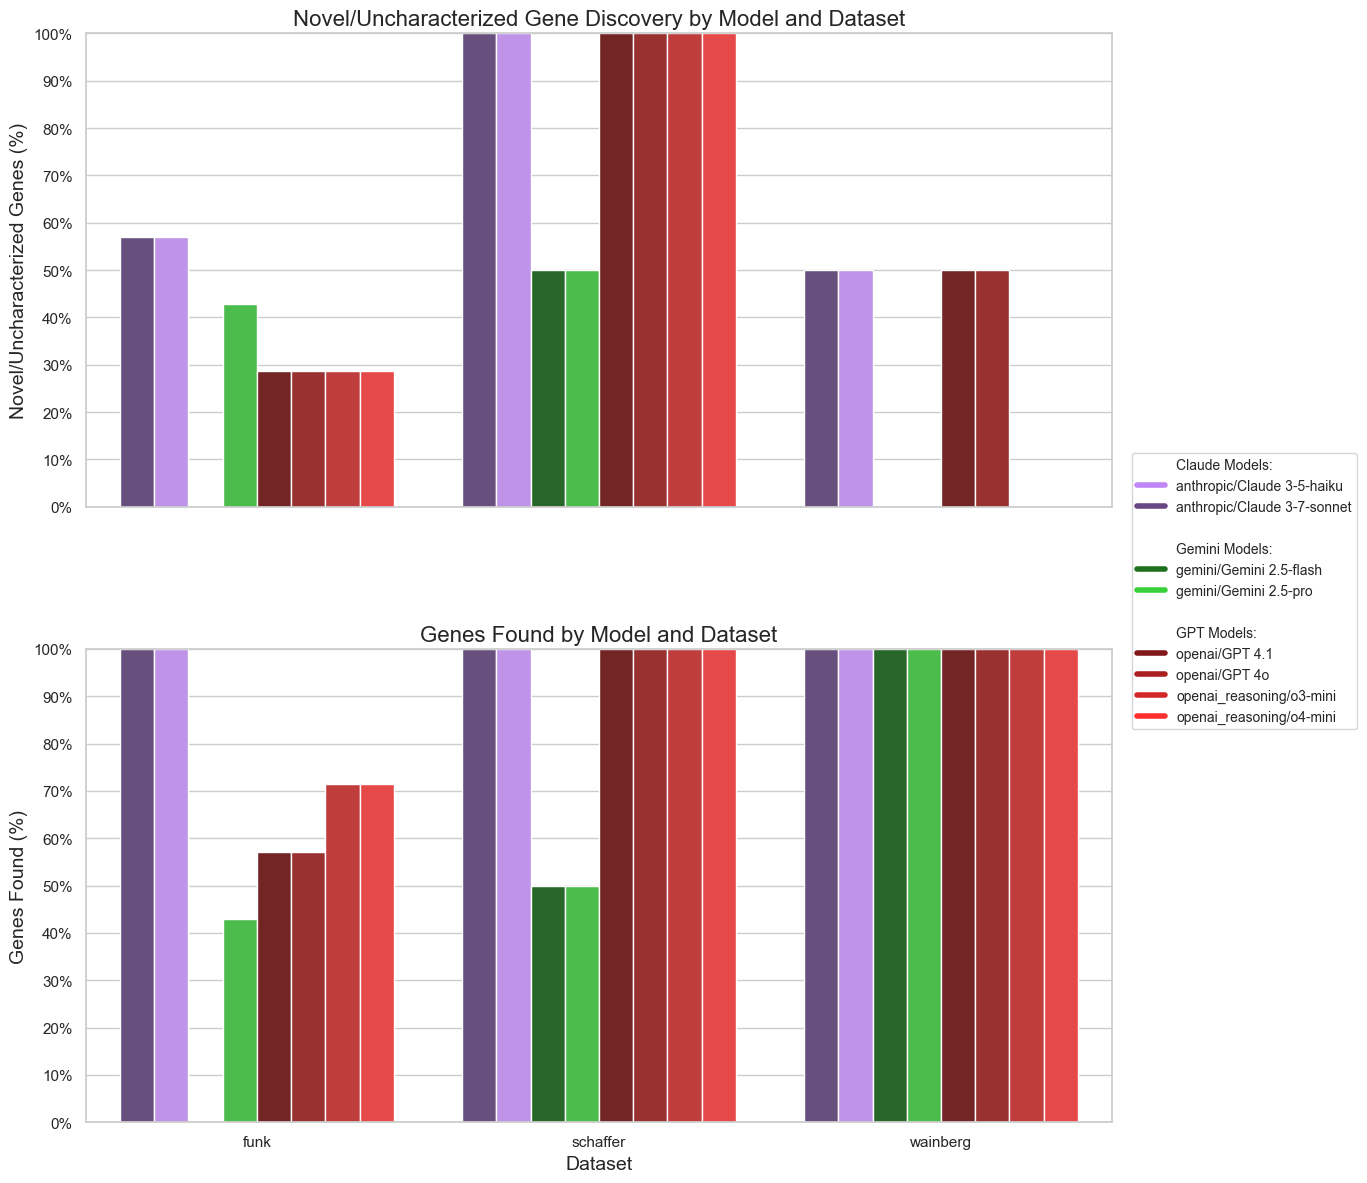

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import MaxNLocator
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors

# Extract percentages from strings
summary_df["Novel/Unchar %"] = (
    summary_df["Novel/Unchar %"].str.rstrip("%").astype(float)
)

# Extract Genes Found percentage from the string format "X/Y (Z%)"
summary_df["Genes Found %"] = summary_df["Genes Found"].apply(
    lambda x: float(x.split("(")[1].split("%")[0])
)

# Create a model type mapping
model_types = {
    "anthropic/claude-3-7-sonnet-20250219": "Claude",
    "anthropic/claude-3-5-haiku-20241022": "Claude",
    "gemini/gemini-2.5-flash-preview-04-17": "Gemini",
    "gemini/gemini-2.5-pro-preview-03-25": "Gemini",
    "openai/gpt-4.1": "GPT",
    "openai/gpt-4o": "GPT",
    "openai_reasoning/o3-mini": "GPT",
    "openai_reasoning/o4-mini": "GPT",
}

# Add model type column
summary_df["Model Type"] = summary_df["Model"].map(model_types)

# Define base colors for each model type
type_base_colors = {
    "Claude": "#9467bd",  # Purple
    "Gemini": "#2ca02c",  # Green
    "GPT": "#d62728",  # Red
}

# Group models by type
models_by_type = {}
for model, model_type in model_types.items():
    if model_type not in models_by_type:
        models_by_type[model_type] = []
    models_by_type[model_type].append(model)

# Create different shades for each model within the same family
model_colors = {}
for model_type, models in models_by_type.items():
    base_color = mcolors.to_rgb(type_base_colors[model_type])

    # Create shades based on number of models
    if len(models) == 2:
        # For 2 models: one darker, one lighter
        model_colors[models[0]] = mcolors.to_hex(
            [c * 0.7 for c in base_color]
        )  # Darker
        model_colors[models[1]] = mcolors.to_hex(
            [min(1.0, c * 1.3) for c in base_color]
        )  # Lighter
    elif len(models) == 4:  # For GPT with 4 models
        # Create 4 shades from dark to light
        shadings = [0.6, 0.8, 1.0, 1.2]
        for i, model in enumerate(models):
            shade_factor = shadings[i]
            model_colors[model] = mcolors.to_hex(
                [min(1.0, c * shade_factor) for c in base_color]
            )
    else:
        # If just one model, use the base color
        for model in models:
            model_colors[model] = type_base_colors[model_type]

# Set the style
sns.set(style="whitegrid")

# Create a figure with two panels
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), sharex=True)

# Panel 1: Novel/Uncharacterized Genes
sns.barplot(
    data=summary_df,
    x="Dataset",
    y="Novel/Unchar %",
    hue="Model",
    palette=model_colors,
    ax=ax1,
)

# Set the title and labels for panel 1
ax1.set_title("Novel/Uncharacterized Gene Discovery by Model and Dataset", fontsize=16)
ax1.set_ylabel("Novel/Uncharacterized Genes (%)", fontsize=14)
ax1.set_ylim(0, 100)  # Slightly higher to give space at the top
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x)}%"))
ax1.yaxis.set_major_locator(MaxNLocator(nbins=10, integer=True))
ax1.get_legend().remove()

# Panel 2: Genes Found
sns.barplot(
    data=summary_df,
    x="Dataset",
    y="Genes Found %",
    hue="Model",
    palette=model_colors,
    ax=ax2,
)

# Set the title and labels for panel 2
ax2.set_title("Genes Found by Model and Dataset", fontsize=16)
ax2.set_xlabel("Dataset", fontsize=14)
ax2.set_ylabel("Genes Found (%)", fontsize=14)
ax2.set_ylim(0, 100)  # Slightly higher to give space at the top
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x)}%"))
ax2.yaxis.set_major_locator(MaxNLocator(nbins=10, integer=True))
ax2.get_legend().remove()

# Create custom legend
legend_elements = []

# Add model elements - group by model type for organization
for model_type in type_base_colors.keys():
    # Add model type header
    legend_elements.append(
        Line2D([0], [0], color="white", lw=0, label=f"{model_type} Models:")
    )

    # Add models of this type
    for model in sorted(models_by_type[model_type]):
        color = model_colors[model]
        # Create a simplified model name for display
        if "claude" in model:
            display_name = (
                model.replace("claude-", "Claude ")
                .replace("-20250219", "")
                .replace("-20241022", "")
            )
        elif "gemini" in model:
            display_name = (
                model.replace("gemini-", "Gemini ")
                .replace("-preview-04-17", "")
                .replace("-preview-03-25", "")
            )
        elif "gpt" in model:
            display_name = model.replace("gpt-", "GPT ")
        else:
            display_name = model

        legend_elements.append(Line2D([0], [0], color=color, lw=4, label=display_name))

    # Add a separator after each group
    if model_type != list(type_base_colors.keys())[-1]:
        legend_elements.append(Line2D([0], [0], color="white", lw=0, label=""))

# Add the legend outside the plot area, positioned between the two panels
fig.legend(
    handles=legend_elements, loc="center right", bbox_to_anchor=(0.98, 0.5), fontsize=10
)

# Adjust layout for the legend and spacing between panels
plt.tight_layout()
plt.subplots_adjust(right=0.8, hspace=0.3)

# Construct the save path
save_path = os.path.join(project_root, "data/benchmarks/analysis_figure.png")

# Save the figure with high dpi (e.g., 300)
plt.savefig(save_path, dpi=300)

plt.show()